In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

## DIOPS - Receita e Despesa

In [4]:
#Caminho da pasta com as bases de dados 
path = r'D:\TCC\TCC\diops'

#Leitura das Bases de Dados
text_files = [f for f in os.listdir(path) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

diops = pd.concat([pd.read_csv(path+'\\'+f, sep=';',usecols=['DATA','REG_ANS','CD_CONTA_CONTABIL','VL_SALDO_FINAL'], decimal= ',', encoding='mbcs') for f in text_files]) #Leitura e concatenação de todas as bases

diops['CD_CONTA_CONTABIL'] = diops['CD_CONTA_CONTABIL'].apply(str) #Converte o campo 'CD_CONTA_CONTABIL' em tipo string

diops = diops[diops['CD_CONTA_CONTABIL'].apply(lambda x: len(str(x))==9)] #Seleciona somente os registro com strings com 9 digitos no campo 'CD_CONTA_CONTABIL'

diops = diops[diops['VL_SALDO_FINAL'] != 0] #Exclui todos os registros iguais a '0' no campo 'VL_SALDO_FINAL'

diops['DATA'] = pd.to_datetime(diops['DATA'], dayfirst=True) #Converte o campo 'DATA' em tipo datetime

diops['DATA'] = diops['DATA'] + pd.DateOffset(months=2) #Modifica o mês no campo 'DATA', alterando todos para o último mês do periodo do trimestre analisado

diops.columns = ['id_calendar', 'cd_ops', 'cd_conta_contabil', 'vl_saldo_final'] #Mudando os nomes das colunas no dataframe

diops = diops[['cd_ops', 'cd_conta_contabil', 'id_calendar', 'vl_saldo_final']] #Reordenando as colunas do dataframe

diops['cd_ops'] = diops['cd_ops'].apply(str)

display(diops.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2987177 entries, 0 to 907072
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   cd_ops             object        
 1   cd_conta_contabil  object        
 2   id_calendar        datetime64[ns]
 3   vl_saldo_final     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 114.0+ MB


None

In [5]:
# filtra contas contábeis relevantes para a análise
diops  = diops.loc[(diops['cd_conta_contabil'].str.startswith('411') & diops['cd_conta_contabil'].str[4].str.contains('1')) | # despesa / corresponsabilidade assumida médico-hospitalar
                    diops['cd_conta_contabil'].str.startswith('31111') | diops['cd_conta_contabil'].str.startswith('31171')]  # receita / corresponsabilidade cedida médico-hospitalar

diops.reset_index(drop=True, inplace=True) #Reindexando o dataframe

#Criando campo 'gr-cc'
diops.loc[diops['cd_conta_contabil'].str.startswith('4'),'gr_cc'] = 'eventos'
diops.loc[diops['cd_conta_contabil'].str.startswith('31111'),'gr_cc'] = 'receita' 
diops.loc[diops['cd_conta_contabil'].str.startswith('31171'),'gr_cc'] = 'corr_cedida'

diops = diops.groupby(['cd_ops', 'cd_conta_contabil', 'id_calendar', 'gr_cc'], as_index=False)['vl_saldo_final'].agg('sum') #Somando os valores do campo 'vl_saldo_final' pelo agrupamento das demais variaveis

diops = diops.pivot_table(values='vl_saldo_final', index=['cd_ops', 'cd_conta_contabil', 'id_calendar'], columns='gr_cc').fillna(0)

diops = pd.DataFrame(diops.to_records()) #Convertendo a tabela pivotada para um objeto tipo dataframe

diops = diops[['cd_ops', 'cd_conta_contabil', 'id_calendar', 'receita', 'eventos', 'corr_cedida']] #Reordenando as colunas

#Criação do campo 'vigencia' pela condição do codigo da conta contabil
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'vigencia'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('1|3|5'),'vigencia'] = 'A'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('2|4|6'),'vigencia'] = 'P'

#Criação do campo 'contratacao'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'contratacao'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('1|2'),'contratacao'] = 'Individual'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('3|4'),'contratacao'] = 'Adesao'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('5|6'),'contratacao'] = 'Empresarial'

#Criação do campo 'financiamento'
diops.loc[diops['cd_conta_contabil'].str[7].str.contains('8'),'financiamento'] = 'corr_assumida'
diops.loc[diops['cd_conta_contabil'].str[5].str.contains('1'),'financiamento'] = 'Pre-estabelecido'
diops.loc[diops['cd_conta_contabil'].str[5].str.contains('2'),'financiamento'] = 'Pos-estabelecido'

diops = diops.drop(diops[diops.vigencia == 'corr_assumida'].index) # exclui corr assumida no campo 'vigencia'

diops['despesa'] = diops['eventos'] - diops['corr_cedida']

diops['ano'] = diops['id_calendar'].dt.to_period('Y')

diops['trimestre'] = diops['id_calendar'].dt.to_period('Q')

diops = diops.groupby(['cd_ops', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], as_index=False).agg({'receita':'sum','despesa':'sum'})

diops.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '01-diops_trimestral_acumulada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops['receita'] = diops['receita'].abs()

diops['despesa'] = diops['despesa'].abs()

display(diops)


,cd_ops,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,receita,despesa
0,27,A,Individual,Pre-estabelecido,2017-09-01,2017,2017Q3,12981.240,0.000
1,27,A,Individual,Pre-estabelecido,2017-12-01,2017,2017Q4,17821.560,0.000
2,27,A,Individual,Pre-estabelecido,2018-03-01,2018,2018Q1,4465.750,0.000
3,27,A,Individual,Pre-estabelecido,2018-06-01,2018,2018Q2,8761.930,0.000
4,27,A,Individual,Pre-estabelecido,2018-09-01,2018,2018Q3,13136.900,0.000
...,...,...,...,...,...,...,...,...,...
60307,884,P,Individual,Pre-estabelecido,2021-03-01,2021,2021Q1,489740.570,6408902.090
60308,884,P,Individual,Pre-estabelecido,2021-06-01,2021,2021Q2,1002331.270,14237176.570
60309,884,P,Individual,Pre-estabelecido,2021-09-01,2021,2021Q3,1497760.340,22156839.620
60310,884,P,Individual,Pre-estabelecido,2021-12-01,2021,2021Q4,1970643.810,29519977.060


In [6]:
###########################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas acumuladas resumidas por trimestre

diops_trimestral_ops = diops.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                                                                    'cd_ops':lambda x: x.nunique()})

diops_trimestral_ops['pct_despesa'] = diops_trimestral_ops.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_trimestral_ops.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_trimestral_ops = diops_trimestral_ops[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_trimestral_ops = diops_trimestral_ops[(diops_trimestral_ops['trimestre'] >= '2018Q1')&(diops_trimestral_ops['trimestre'] < '2022Q1')]

diops_trimestral_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '02-diops_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_trimestral_ops

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,45.810,35.970,700,78.520
2018Q2,95.320,77.120,708,80.910
2018Q3,145.270,118.640,709,81.670
2018Q4,205.140,168.460,707,82.120
2019Q1,50.580,40.210,688,79.500
2019Q2,100.300,82.450,686,82.200
2019Q3,156.190,129.620,686,82.990
2019Q4,209.760,172.850,688,82.400
2020Q1,54.590,42.430,673,77.720


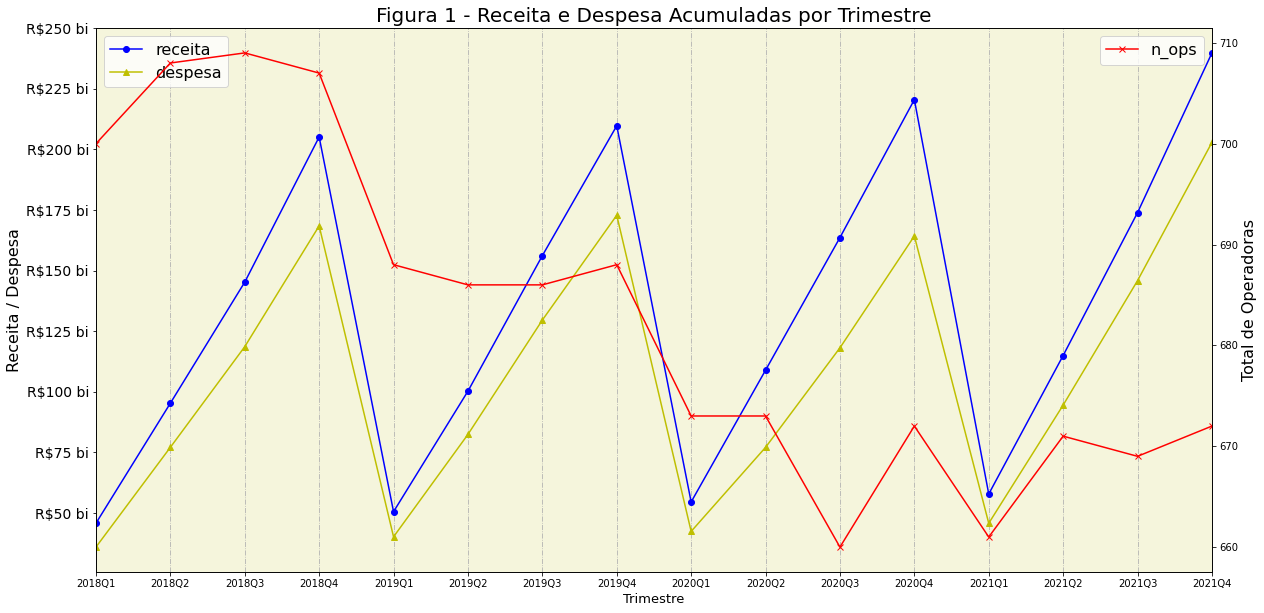

In [7]:
from matplotlib.pyplot import xticks

fig,ax1 = plt.subplots()

diops_trimestral_ops.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre',fontsize = 20)
ax1.set_xticks(diops_trimestral_ops.index)
ax1.set_xticklabels(diops_trimestral_ops.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_trimestral_ops.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_trimestral_ops.index)
ax2.set_xticklabels(diops_trimestral_ops.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

# SIB

In [8]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '03-sib.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [9]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [10]:
sib_media_agregada = sib.groupby(['ano', 'trimestre'],  as_index=False).agg({'benef':lambda x: round(sum(x)/3,0),
                                                                             'cd_ops':lambda x: x.nunique()})

sib_media_agregada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '04-sib_media_agregada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_media_agregada

,ano,trimestre,benef,cd_ops
0,2017,2017Q3,23087643.000,1075
1,2017,2017Q4,69417614.000,1073
2,2018,2018Q1,69491979.000,1064
3,2018,2018Q2,70069275.000,1061
4,2018,2018Q3,70793574.000,1055
5,2018,2018Q4,71284403.000,1050
6,2019,2019Q1,71274410.000,1032
7,2019,2019Q2,71378857.000,1020
8,2019,2019Q3,71780017.000,1015
9,2019,2019Q4,72539561.000,1009


In [11]:
#Filtra segmentos alvo da análise e totaliza por mês, operadora e tipo de plano.

#filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
#filtro2 = sib['vigencia'].isin(['P'])
#filtro3 = sib['financiamento'] != 'Pós-estabelecido'
#filtro4 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

#sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3 & filtro4 ]


filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '05-sib_filtrada.csv', sep=';', encoding='mbcs', decimal=',')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [12]:
sib_filtrada_analise = sib_filtrada.groupby(['contratacao', 'ano', 'trimestre'],  as_index=False).agg({ 'benef':lambda x: round(sum(x)/3,0),
                                                                                                        'cd_ops':lambda x: x.nunique()})

sib_filtrada_analise = pd.DataFrame(sib_filtrada_analise.pivot_table(index='trimestre', columns='contratacao', values=['benef','cd_ops']).to_records())

sib_filtrada_analise.columns = ['trimestre','benef.Adesao','benef.Empresarial','benef.Individual','n_ops.Adesao','n_ops.Empresarial','n_ops.Individual']

sib_filtrada_analise = sib_filtrada_analise[(sib_filtrada_analise.trimestre >= '2018Q1') & (sib_filtrada_analise.trimestre < '2022Q1')]

sib_filtrada_analise.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '16-sib_analise_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada_analise.set_index('trimestre', inplace=True)

sib_filtrada_analise

,benef.Adesao,benef.Empresarial,benef.Individual,n_ops.Adesao,n_ops.Empresarial,n_ops.Individual
trimestre,,,,,,
2018Q1,4999117.000,29881637.000,8077513.000,554,665,547
2018Q2,5019122.000,30028083.000,8062089.000,557,659,542
2018Q3,5002806.000,30149875.000,8045547.000,554,659,541
2018Q4,5007825.000,30286803.000,8054624.000,554,656,537
2019Q1,4996316.000,30225921.000,8012163.000,548,645,525
2019Q2,5024662.000,30281003.000,8008683.000,546,639,519
2019Q3,5021194.000,30319725.000,8013662.000,540,632,521
2019Q4,5047480.000,30446335.000,8025205.000,541,630,517
2020Q1,5070917.000,30473749.000,8006754.000,540,633,518


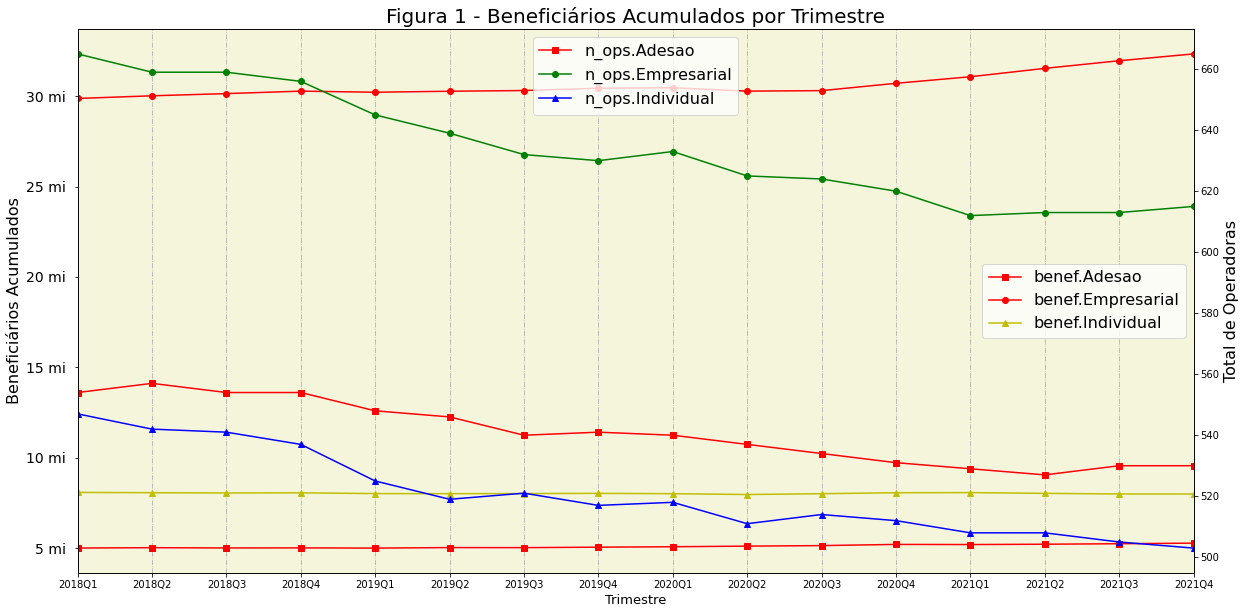

In [13]:
df_plot = sib_filtrada_analise.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['benef.Adesao','benef.Empresarial','benef.Individual'], figsize=(20,10), style=['rs-','ro-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Beneficiários Acumulados por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['{:.0f} mi '.format(x/1e6) for x in yticks], fontsize = 14)
ax1.set_ylabel('Beneficiários Acumulados', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops.Adesao','n_ops.Empresarial','n_ops.Individual'], figsize=(20,10), style=['rs-','go-','b^-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [14]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.667,4,3


In [15]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '05-sib3.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
7,2017,27,P,Empresarial,Pre-estabelecido,2017-12-01,2017Q4,17190
8,2017,27,P,Individual,Pre-estabelecido,2017-09-01,2017Q3,631
...,...,...,...,...,...,...,...,...
106440,2022,422771,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,91
106442,2022,422827,P,Adesao,Pre-estabelecido,2022-03-01,2022Q1,33
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646


In [16]:
sib_filtrada_analise_2 = sib_filtrada.groupby(['contratacao', 'ano', 'trimestre'],  as_index=False).agg({ 'benef':lambda x: round(sum(x),0),
                                                                                                          'cd_ops':lambda x: x.nunique()})

sib_filtrada_analise_2.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '17-sib_analise2_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

sib_filtrada_analise_2.head()

,contratacao,ano,trimestre,benef,cd_ops
0,Adesao,2017,2017Q3,5037647,555
1,Adesao,2017,2017Q4,5017839,554
2,Adesao,2018,2018Q1,5002413,553
3,Adesao,2018,2018Q2,5021061,555
4,Adesao,2018,2018Q3,5006470,551


In [17]:
#################################################################################################################################
#OPERADORAS
################################################################################################################################

path_operadoras = r'D:\TCC\TCC\Cadop'

text_files_operadoras = [f for f in os.listdir(path_operadoras) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

cadop = pd.concat([pd.read_csv(path_operadoras+'\\'+f, sep=';', encoding="ANSI") for f in text_files_operadoras]) #Leitura e concatenação de todas as bases

#cadop = cadop[['Registro_ANS', 'Razao_Social', 'Modalidade', 'Data_Registro_ANS', 'Data_Descredenciamento']]

cadop = cadop[['CD_OPERADO', 'RAZAO_SOCIAL', 'MODALIDADE', 'DATA_REGISTRO_ANS', 'DATA_DESCREDENCIAMENTO']]

cadop.columns = ['cd_ops', 'razao_social', 'modalidade', 'dt_registro', 'dt_cancelamento']

cadop['dt_registro'] = pd.to_datetime(cadop['dt_registro'], dayfirst=True)

cadop['dt_cancelamento'] = pd.to_datetime(cadop['dt_cancelamento'], dayfirst=True)

cadop = pd.merge(cadop, ops, on='cd_ops', how='left')

cadop.drop(['benef'], axis='columns', inplace=True)

cadop['port_ops'] = cadop['port_ops'].fillna('Pequeno')

cadop['modalidade'] = cadop['modalidade'].str.replace('Seguradora Especializada em Saúde','Seguradora')

cadop = cadop.loc[cadop['modalidade'].isin(['Autogestão', 'Cooperativa Médica', 'Filantropia', 'Medicina de Grupo', 'Seguradora'])]

cadop['ano - dt_cancelamento'] = cadop['dt_cancelamento'].dt.year

cadop['ano - dt_registro'] = cadop['dt_registro'].dt.year

cadop['lg_cancelada'] = np.select([cadop['ano - dt_cancelamento'] <= 2021, (cadop['ano - dt_cancelamento'] != "NaN")],[1,0]) # Filtro de fim da Operação

cadop['lg_nova_ops'] = np.where(cadop['ano - dt_registro'] >= 2018, 1, 0) # Filtro de inicio da Operação

cadop = cadop[['cd_ops', 'razao_social', 'modalidade', 'port_ops', 'lg_cancelada', 'lg_nova_ops']]

cadop['cd_ops'] = cadop['cd_ops'].astype('str')

cadop.to_csv(f'D:/TCC/TCC/codigos/preparacao_dados' + '\\' + '18-cadop.csv', sep=';', index=False, encoding='mbcs', decimal=',')

cadop

,cd_ops,razao_social,modalidade,port_ops,lg_cancelada,lg_nova_ops
0,418374,CAIXA DE ASSISTÊNCIA DO SETOR DE ENERGIA -EVIDA -ASSISTÊNCIA À SAÚDE,Autogestão,Pequeno,0,0
3,421421,2CARE OPERADORA DE SAÚDE LTDA.,Medicina de Grupo,Médio,0,1
5,406708,A.P.S ASSISTÊNCIA PERSONALIZADA À SAÚDE LTDA,Medicina de Grupo,Pequeno,0,0
9,314668,ABERTTA SAÚDE - ASSOCIAÇÃO BENEFICENTE DOS EMPREGADOS DA ARCELORMITTAL NO BRASIL,Autogestão,Médio,0,0
16,419168,ADPART M2 ADMINISTRAÇÃO E PARTICIPAÇÕES LTDA,Medicina de Grupo,Pequeno,0,0
...,...,...,...,...,...,...
4022,345628,WMS SUPERMERCADOS DO BRASIL LTDA,Autogestão,Pequeno,1,0
4023,320633,WOLF EQUIPAMENTOS DE PERFURAÇÃO LTDA,Autogestão,Pequeno,1,0
4025,327492,WORLD MED CARD SISTEMAS E LANÇAMENTOS LTDA,Medicina de Grupo,Pequeno,1,0
4026,339750,WS OPERADORA DE PLANOS DE SAÚDE LTDA - EM LIQUIDAÇÃO EXTRAJUDICIAL,Medicina de Grupo,Pequeno,1,0


In [18]:
cadop_analise = cadop.agg(  n_ops=('cd_ops', lambda x: x.nunique()),
                            n_canceladas = ('lg_cancelada','sum'),
                            n_novas_ops = ('lg_nova_ops', 'sum'))

cadop_analise.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '19-cadop_analise.csv', sep=';', index=False, encoding='mbcs', decimal=',')

cadop_analise

,cd_ops,lg_cancelada,lg_nova_ops
n_ops,2599.000,NaN,NaN
n_canceladas,NaN,1872.000,NaN
n_novas_ops,NaN,NaN,65.000


# DIOPS - TCC - Receita e Despesa desacumulados

In [19]:

############################################################################################################################################################################################
#                                                                                           DIOPS TCC
############################################################################################################################################################################################

#Cópia da base diops acumulada
diops_temp = diops.copy()

diops_temp['ref1'] = (  diops_temp['cd_ops'].map(str) + 
                        diops_temp['vigencia'].map(str) + 
                        diops_temp['contratacao'].map(str) + 
                        diops_temp['financiamento'].map(str) + 
                        diops_temp['ano'].map(str))

diops_temp['ref2'] = (  diops_temp['cd_ops'].map(str) + 
                        diops_temp['vigencia'].map(str) + 
                        diops_temp['contratacao'].map(str) + 
                        diops_temp['financiamento'].map(str) + 
                        diops_temp['ano'].map(str) + 
                        diops_temp['trimestre'].map(str))

#Cálculo das diferenças dos valores acumulados
diops_receita_temp = diops_temp[['ref1', 'ref2', 'receita']]

diops_receita_temp =  diops_receita_temp.set_index(['ref1', 'ref2']).sort_index()[['receita']]
diops_receita_temp['dif_receita'] = np.nan
idx = pd.IndexSlice

for ix in diops_receita_temp.index.levels[0]:
    diops_receita_temp.loc[ idx[ix,:], 'dif_receita'] = diops_receita_temp.loc[idx[ix,:],'receita'].diff()
    
diops_despesa_temp = diops_temp[['ref1', 'ref2', 'despesa']]

diops_despesa_temp =  diops_despesa_temp.set_index(['ref1', 'ref2']).sort_index()[['despesa']]
diops_despesa_temp['dif_despesa'] = np.nan
idx = pd.IndexSlice

for ix in diops_despesa_temp.index.levels[0]:
    diops_despesa_temp.loc[ idx[ix,:], 'dif_despesa'] = diops_despesa_temp.loc[idx[ix,:],'despesa'].diff()

diops_temp1 =  pd.merge(diops_temp, diops_receita_temp, on='ref2', how='left')

diops_temp2 =  pd.merge(diops_temp1, diops_despesa_temp, on='ref2', how='left')

diops_tcc = diops_temp2.drop(columns = ['ref1','ref2', 'receita_y', 'despesa_y'])

diops_tcc.dif_receita.fillna(diops_tcc.receita_x, inplace=True)

diops_tcc.dif_despesa.fillna(diops_tcc.despesa_x, inplace=True)

diops_tcc = diops_tcc.drop(columns = ['receita_x', 'despesa_x'])

diops_tcc.rename(columns = {'dif_receita':'receita', 'dif_despesa':'despesa'}, inplace = True)

del diops_temp, diops_receita_temp, diops_despesa_temp, diops_temp1, diops_temp2

#print('diops_tcc')
#print(diops_tcc)

diops_tcc.to_csv(f'D:\TCC\TCC\codigos\preparacao_dados' + '\\' + '04-diops_trimestral_tcc.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc['receita'] = diops_tcc['receita'].abs()

diops_tcc['despesa'] = diops_tcc['despesa'].abs()

diops_tcc = diops_tcc[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','receita','despesa']]

diops_tcc

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa
0,2017,27,A,Individual,Pre-estabelecido,2017-09-01,2017Q3,12981.240,0.000
1,2017,27,A,Individual,Pre-estabelecido,2017-12-01,2017Q4,4840.320,0.000
2,2018,27,A,Individual,Pre-estabelecido,2018-03-01,2018Q1,4465.750,0.000
3,2018,27,A,Individual,Pre-estabelecido,2018-06-01,2018Q2,4296.180,0.000
4,2018,27,A,Individual,Pre-estabelecido,2018-09-01,2018Q3,4374.970,0.000
...,...,...,...,...,...,...,...,...,...
60307,2021,884,P,Individual,Pre-estabelecido,2021-03-01,2021Q1,489740.570,6408902.090
60308,2021,884,P,Individual,Pre-estabelecido,2021-06-01,2021Q2,512590.700,7828274.480
60309,2021,884,P,Individual,Pre-estabelecido,2021-09-01,2021Q3,495429.070,7919663.050
60310,2021,884,P,Individual,Pre-estabelecido,2021-12-01,2021Q4,472883.470,7363137.440


## Reunião das Bases

In [20]:
ans = pd.merge(diops_tcc,sib_filtrada, how='left', on=['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre'])

ans = pd.merge(ans,cadop, how='left', on=['cd_ops'])

ans = ans[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'trimestre', 'receita', 'despesa', 'benef', 'lg_cancelada', 'lg_nova_ops']]

ans

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2017,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2017-09-01,2017Q3,12981.240,0.000,NaN,1.000,0.000
1,2017,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2017-12-01,2017Q4,4840.320,0.000,NaN,1.000,0.000
2,2018,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2018-03-01,2018Q1,4465.750,0.000,NaN,1.000,0.000
3,2018,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2018-06-01,2018Q2,4296.180,0.000,NaN,1.000,0.000
4,2018,27,SALUTAR SAÚDE SEGURADORA S.A. - EM LIQUIDAÇÃO EXTRAJUDICIAL,Seguradora,Pequeno,A,Individual,Pre-estabelecido,2018-09-01,2018Q3,4374.970,0.000,NaN,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60307,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-03-01,2021Q1,489740.570,6408902.090,64.000,0.000,0.000
60308,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-06-01,2021Q2,512590.700,7828274.480,63.000,0.000,0.000
60309,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-09-01,2021Q3,495429.070,7919663.050,62.000,0.000,0.000
60310,2021,884,ITAUSEG SAÚDE S.A.,Seguradora,Pequeno,P,Individual,Pre-estabelecido,2021-12-01,2021Q4,472883.470,7363137.440,62.000,0.000,0.000


In [21]:
ans_analise = ans.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': lambda x: sum_million(x),
                                                                    'cd_ops':lambda x: x.nunique()})

ans_analise['pct_despesa'] = ans_analise.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_analise.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_analise = ans_analise[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_analise = ans_analise[(ans_analise.trimestre > '2017Q4') & (ans_analise.trimestre < '2022Q1')]

ans_analise.set_index('trimestre', inplace=True)

ans_analise

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,45.810,35.970,40.700,700,78.520
2018Q2,49.610,41.180,41.730,708,83.010
2018Q3,50.030,44.320,41.820,709,88.590
2018Q4,61.130,55.650,41.780,707,91.040
2019Q1,50.580,40.210,41.720,688,79.500
2019Q2,51.420,43.600,41.790,686,84.790
2019Q3,54.840,46.760,42.560,686,85.270
2019Q4,55.970,45.740,42.380,688,81.720
2020Q1,54.590,42.430,42.660,673,77.720


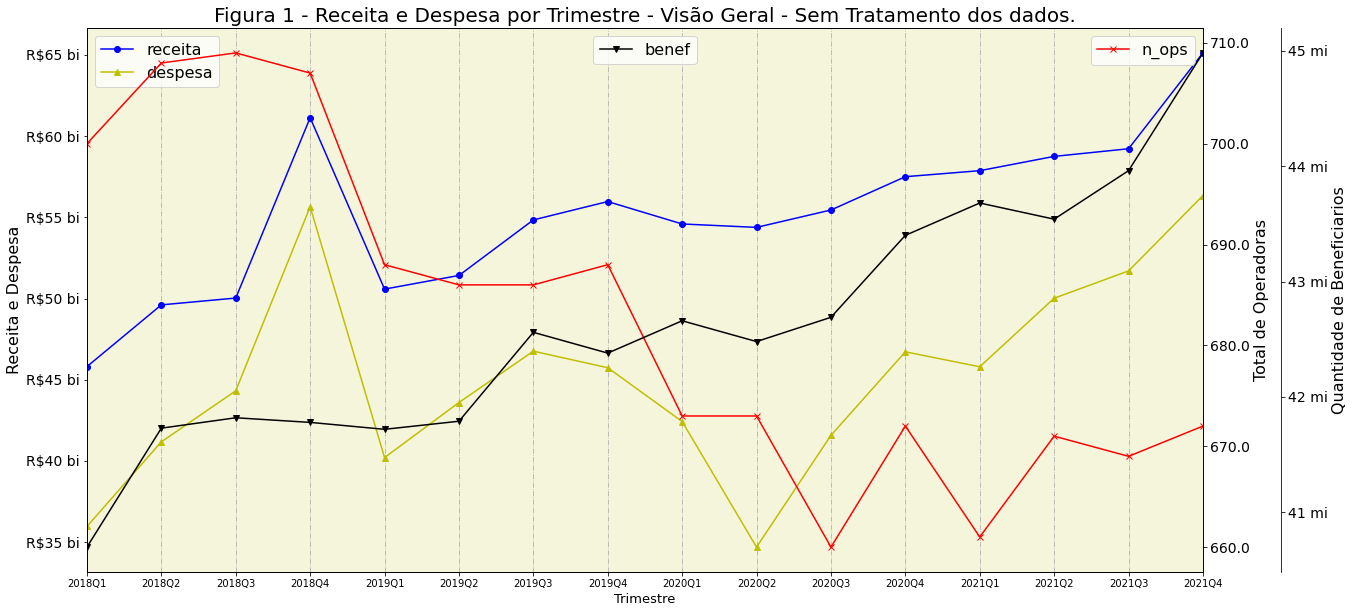

In [22]:
df_plot = ans_analise.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Visão Geral - Sem Tratamento dos dados.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

## Filtragem dos dados

In [29]:
ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

ans_filt = ans[(ans['lg_cancelada']!=1) & (ans['benef']!=np.nan)].reset_index(drop=True)

### Individual - Seguradoras

In [30]:
contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

ans_filt_ind_seg = ans_filt[(ans_filt['contratacao']=='Individual') &((ans_filt['modalidade']=='Seguradora'))].reset_index(drop=True)

ans_filt_ind_seg = ans_filt_ind_seg[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_ind_seg.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),
                                                                           'despesa':lambda x: sum_million(x)}).head()

receita  despesa
ano  cd_ops razao_social                          trimestre                  
2017 477    SUL AMÉRICA SEGURADORA DE SAÚDE S.A.  2017Q3      38.010   42.950
                                                  2017Q4      13.590   13.330
     5711   BRADESCO SAÚDE S.A.                   2017Q3     346.720  343.740
                                                  2017Q4     124.860  112.000
     6246   SUL AMERICA COMPANHIA DE SEGURO SAÚDE 2017Q3     384.920  370.990

In [32]:
ans_filt_ind_seg_agrup = ans_filt_ind_seg.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                             'despesa':lambda x: sum_million(x),
                                                                                             'benef': 'sum',
                                                                                             'cd_ops':lambda x: x.nunique()})

ans_filt_ind_seg_agrup['pct_despesa'] = ans_filt_ind_seg_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_ind_seg_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_ind_seg_agrup = ans_filt_ind_seg_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_ind_seg_agrup = ans_filt_ind_seg_agrup[(ans_filt_ind_seg_agrup.trimestre > '2017Q4') & (ans_filt_ind_seg_agrup.trimestre < '2022Q1')]

ans_filt_ind_seg_agrup[['n_ops','benef']] = ans_filt_ind_seg_agrup[['n_ops','benef']].astype('int')

ans_filt_ind_seg_agrup.set_index('trimestre', inplace=True)

ans_filt_ind_seg_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,291.320,250.410,55593,5,85.960
2018Q2,300.340,277.630,54200,5,92.440
2018Q3,294.750,290.060,52992,5,98.410
2018Q4,313.810,282.560,51520,5,90.040
2019Q1,311.780,279.790,50264,5,89.740
2019Q2,312.280,285.860,49032,5,91.540
2019Q3,319.070,322.840,47820,5,101.180
2019Q4,329.070,303.230,46607,5,92.150
2020Q1,325.340,298.370,45612,5,91.710


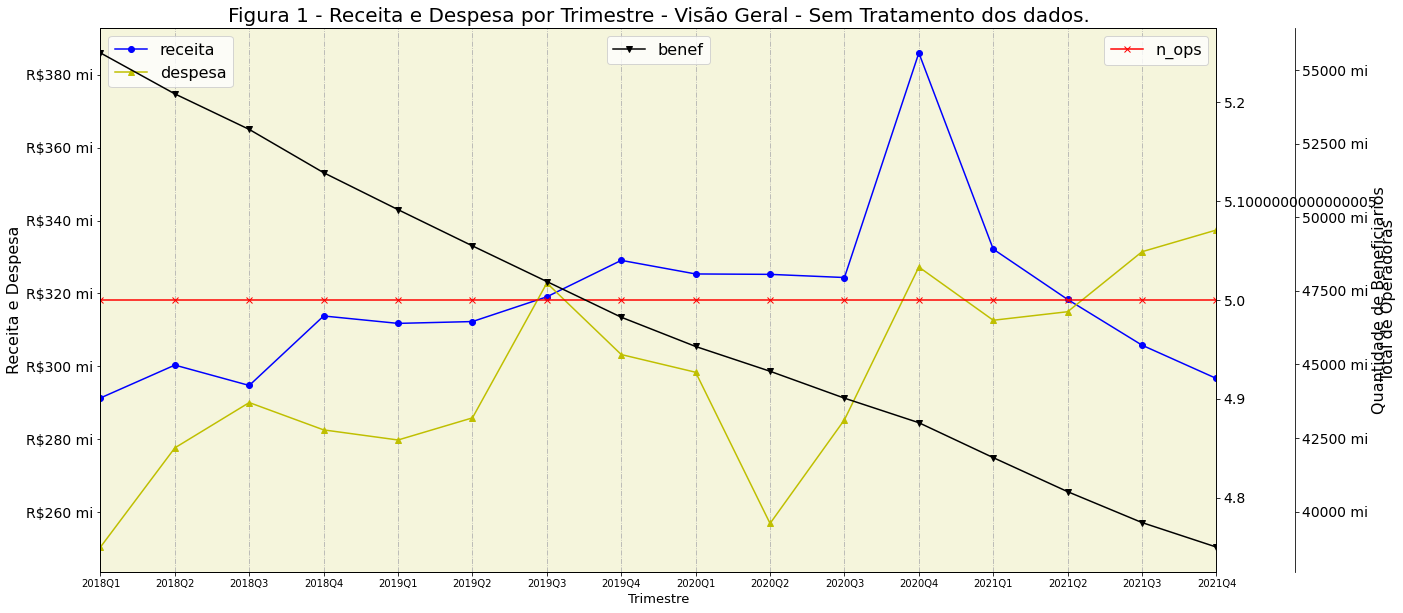

In [33]:
df_plot = ans_filt_ind_seg_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Visão Geral - Sem Tratamento dos dados.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [34]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_ind_seg_agrup_ops = ans_filt_ind_seg.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                         'despesa':lambda x: sum_million(x)})

ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_filt_ind_seg_agrup_ops.head()

,ano,cd_ops,trimestre,receita,despesa
4,2017,6246,2017Q3,384.920,370.990
2,2017,5711,2017Q3,346.720,343.740
5,2017,6246,2017Q4,133.940,133.410
3,2017,5711,2017Q4,124.860,112.000
0,2017,477,2017Q3,38.010,42.950


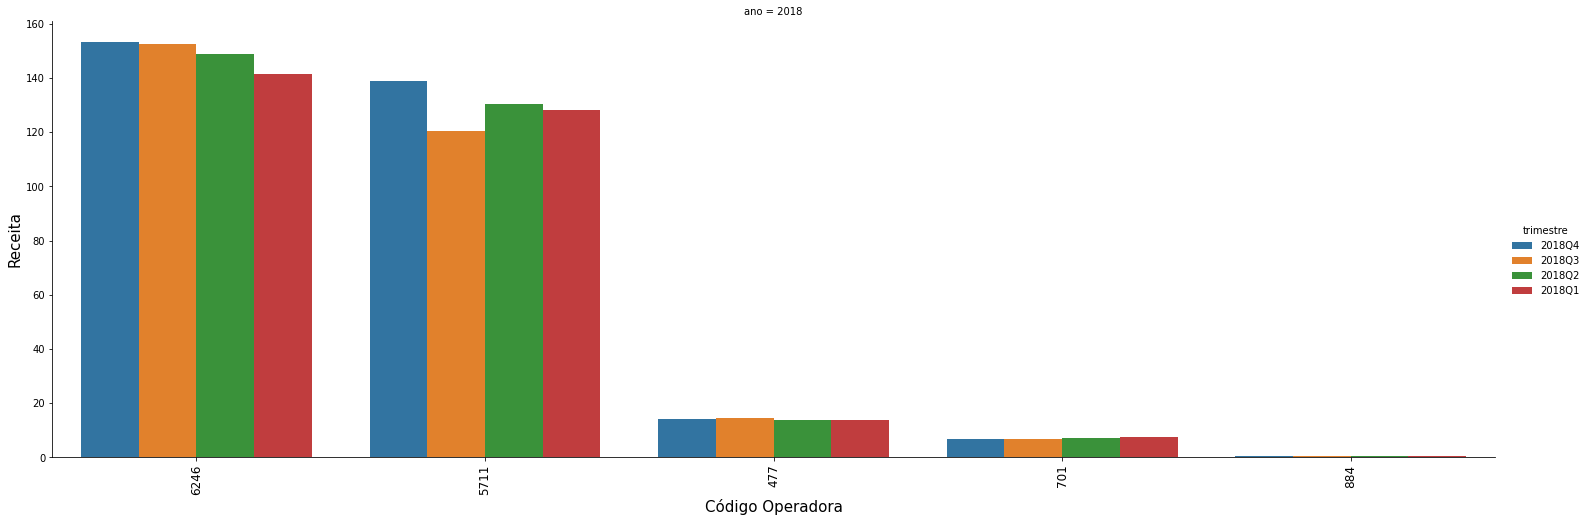

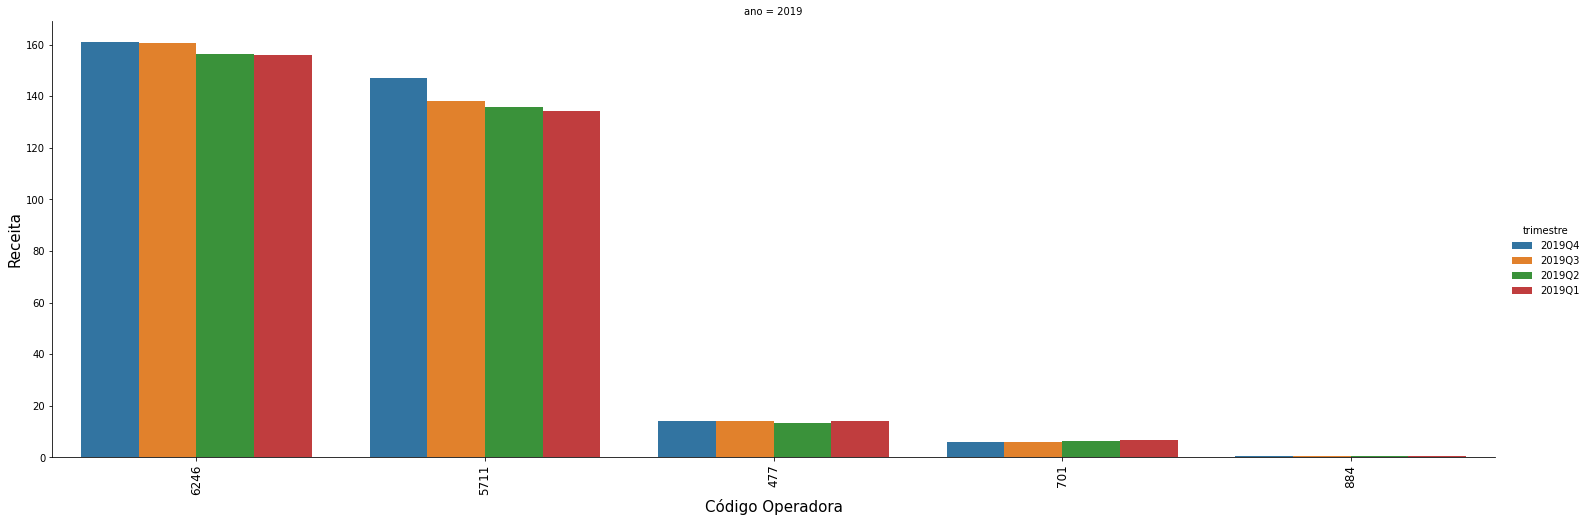

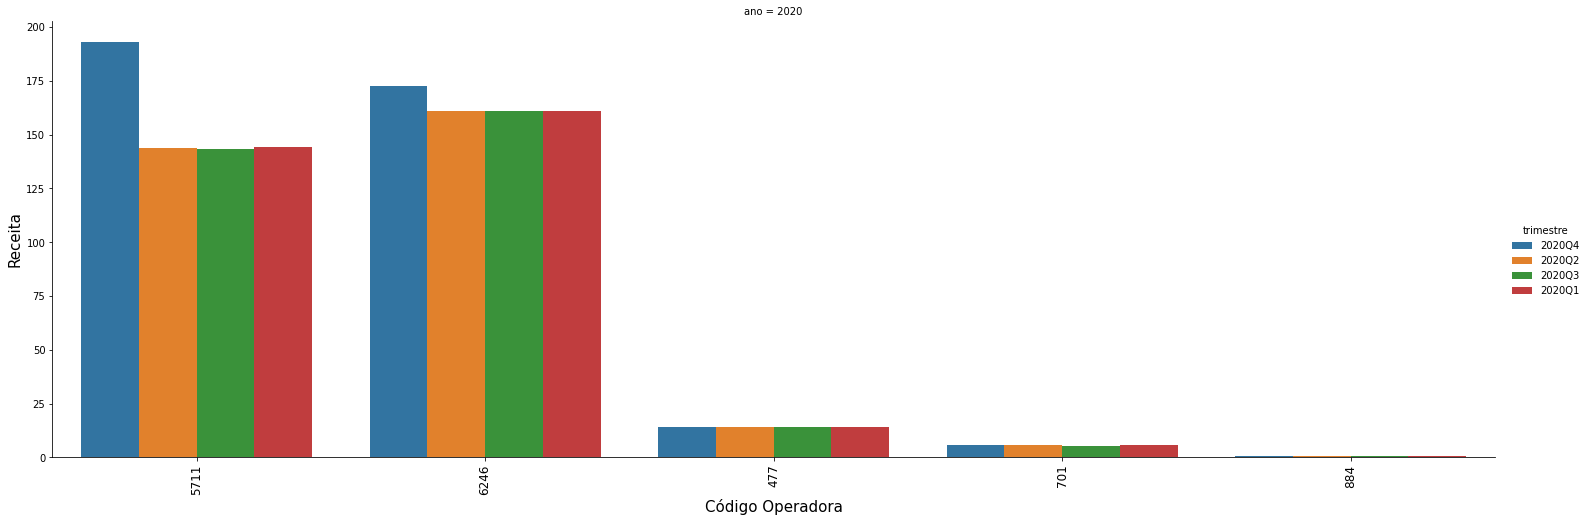

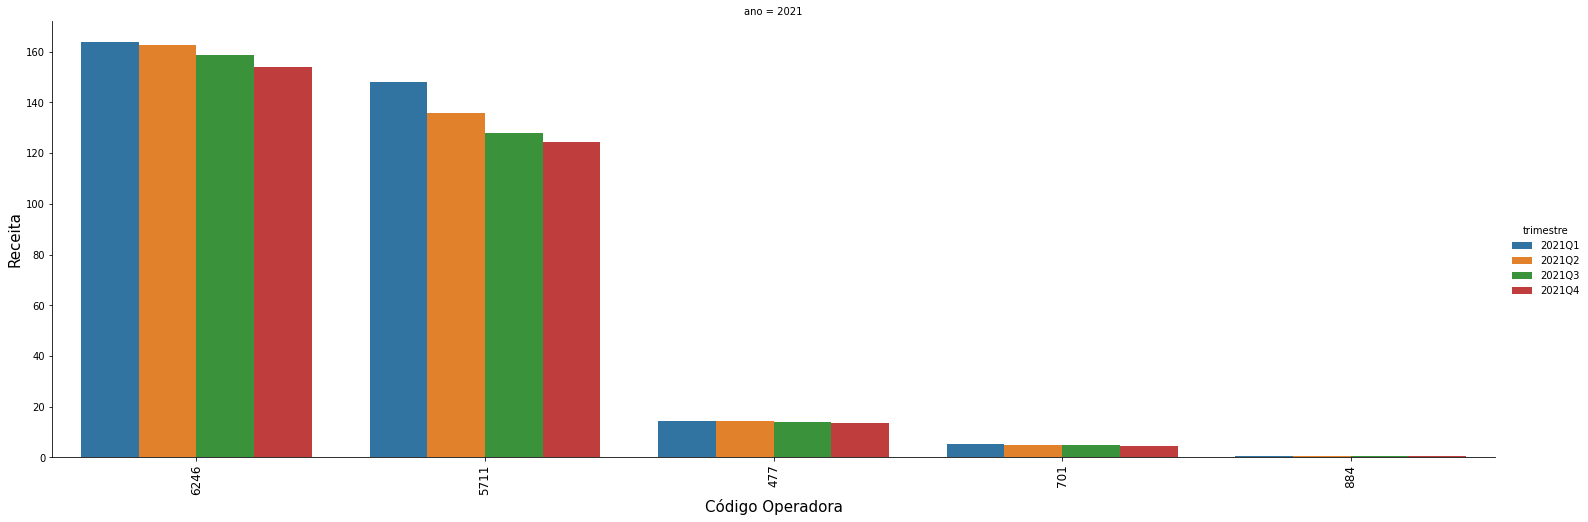

In [35]:
df_plot = ans_filt_ind_seg_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

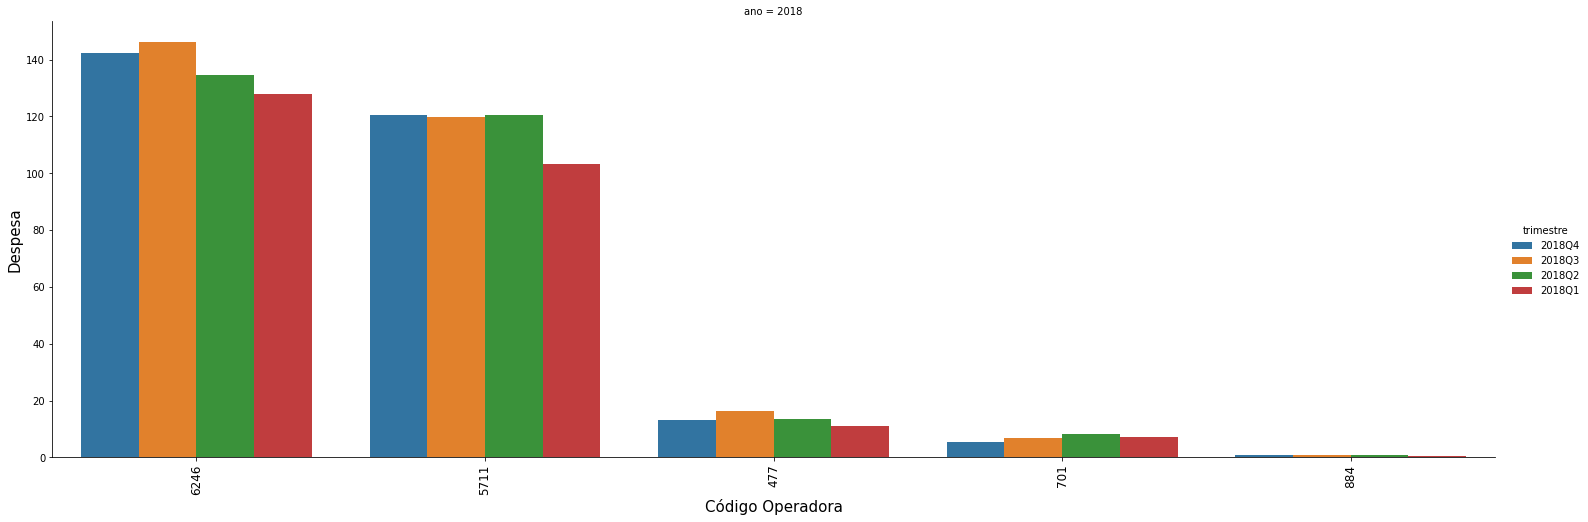

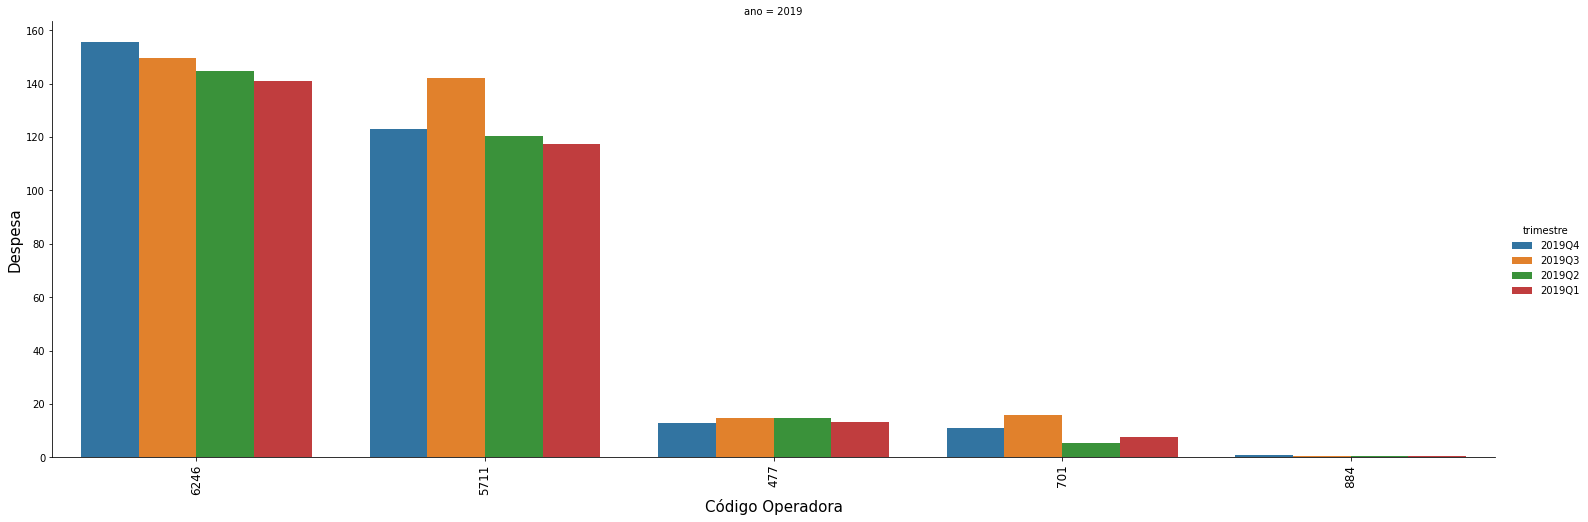

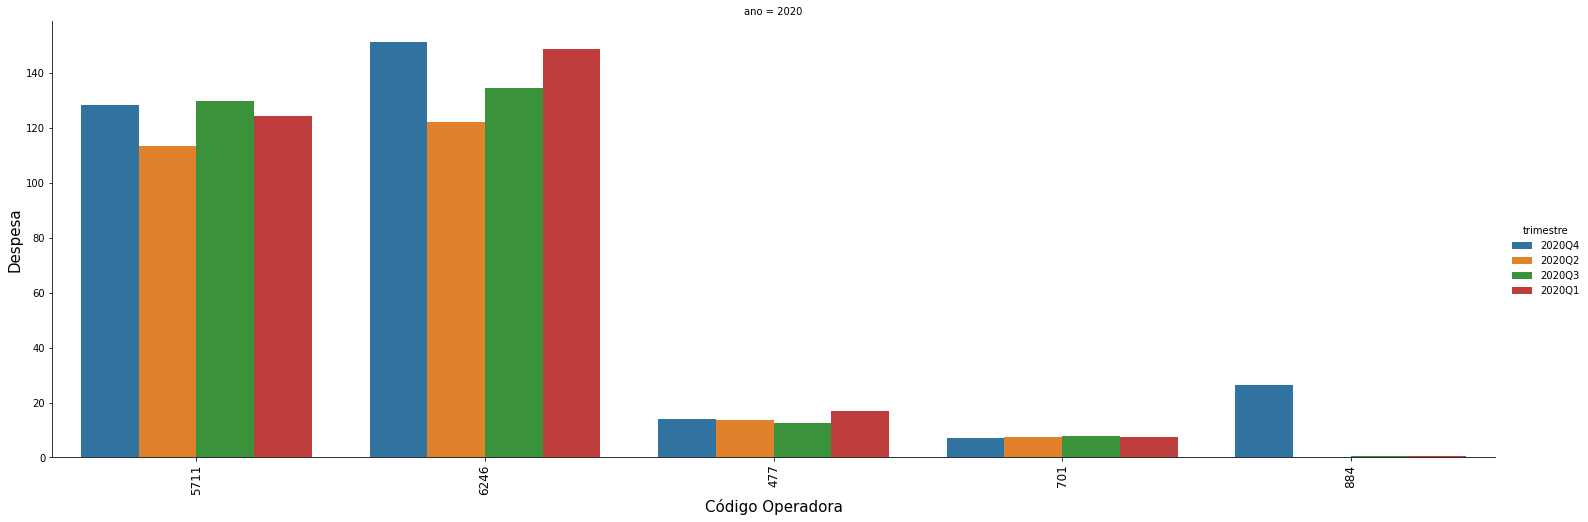

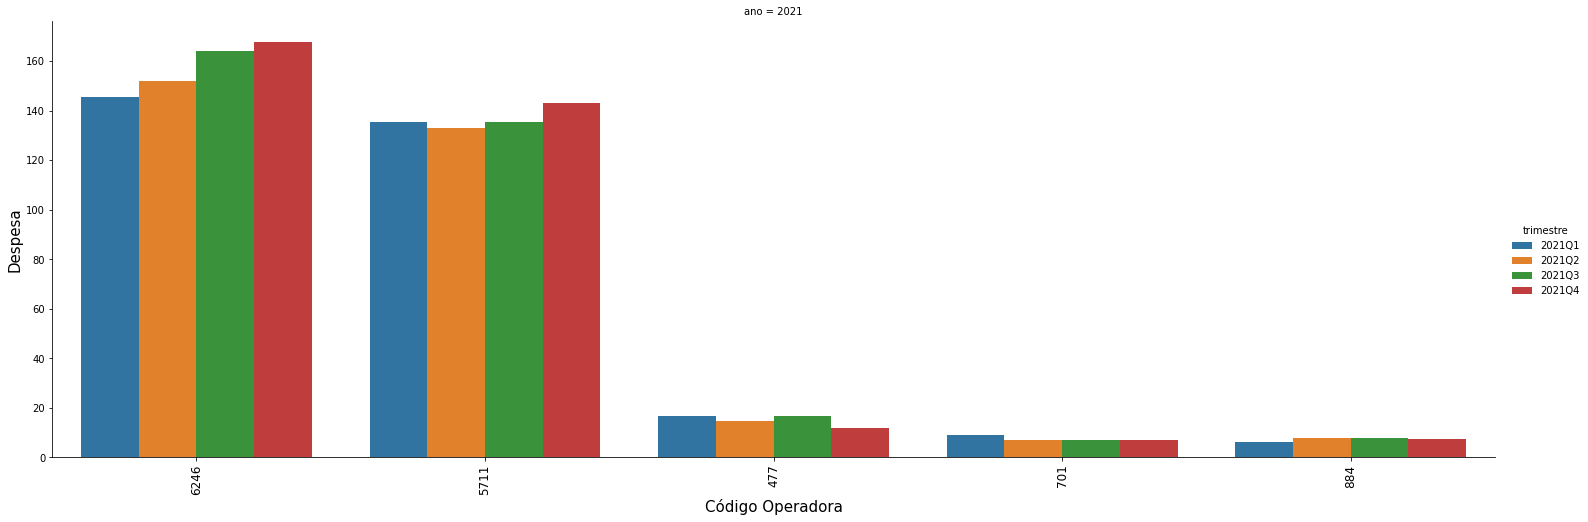

In [36]:
df_plot = ans_filt_ind_seg_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Limpeza e Tratamento de Dados

In [95]:
diops_tcc_analise1 = diops_tcc.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                          'despesa':'sum'})

diops_tcc_analise1 = diops_tcc_analise1[(diops_tcc_analise1['ano']>'2017') & (diops_tcc_analise1['ano']<'2022')] #Filtra anos de 2018 até 2021

diops_tcc_analise1 = diops_tcc_analise1.drop(diops_tcc_analise1[(diops_tcc_analise1.receita != 0) & (diops_tcc_analise1.despesa == 0)].index)

diops_tcc_analise1 = diops_tcc_analise1.drop(diops_tcc_analise1[(diops_tcc_analise1.receita == 0) & (diops_tcc_analise1.despesa != 0)].index)

diops_tcc_analise1 = diops_tcc_analise1.drop(diops_tcc_analise1[(diops_tcc_analise1.receita == 0) & (diops_tcc_analise1.despesa == 0)].index)

diops_tcc_analise1

,ano,cd_ops,trimestre,receita,despesa
1428,2018,27,2018Q1,23205753.800,21011412.760
1429,2018,27,2018Q2,23299209.530,19557072.570
1430,2018,27,2018Q3,19029243.290,19869707.410
1431,2018,27,2018Q4,13584160.740,15486481.580
1432,2018,300012,2018Q1,4890415.420,3805978.920
...,...,...,...,...,...
12346,2021,701,2021Q4,871792540.860,726156850.330
12347,2021,884,2021Q1,50117093.710,62328456.740
12348,2021,884,2021Q2,51133604.040,75619208.010
12349,2021,884,2021Q3,49093642.160,68671675.190


In [96]:
diops_tcc_analise2 = diops_tcc_analise1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
diops_tcc_analise2.head(15)

,ano,cd_ops,n_trimestre
0,2018,27,4
1,2018,300012,4
2,2018,300136,4
3,2018,300713,4
4,2018,301060,4
5,2018,301124,4
6,2018,301574,4
7,2018,301728,4
8,2018,301744,4
9,2018,302091,4


In [97]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
diops_tcc_analise_complete = diops_tcc_analise2[diops_tcc_analise2['n_trimestre']==4].reset_index(drop=True)
diops_tcc_analise_complete = diops_tcc_analise_complete[['ano','cd_ops']]
diops_tcc_analise_complete.head()

,ano,cd_ops
0,2018,27
1,2018,300012
2,2018,300136
3,2018,300713
4,2018,301060


In [98]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
diops_tcc_analise_imcomplete = diops_tcc_analise2[diops_tcc_analise2['n_trimestre']!=4].reset_index(drop=True)
diops_tcc_analise_imcomplete = diops_tcc_analise_imcomplete[['ano','cd_ops']]
diops_tcc_analise_imcomplete.head()

,ano,cd_ops
0,2018,302228
1,2018,308005
2,2018,309401
3,2018,309907
4,2018,311961


In [99]:
#Filtra as operadoras com lançamentos completos
keys = list(diops_tcc_analise_complete.columns.values)
i1 = diops_tcc_analise1.set_index(keys).index
i2 = diops_tcc_analise_complete.set_index(keys).index

diops_tcc_analise3 =  diops_tcc_analise1[i1.isin(i2)]

#diops_tcc_analise3[diops_tcc_analise3['receita']==0]

diops_tcc_analise3.head()

#Verificação da filtragem
#diops_tcc_analise_vef = diops_tcc_analise_temp[(diops_tcc_analise_temp['ano']>'2017') & (diops_tcc_analise_temp['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
1428,2018,27,2018Q1,23205753.800,21011412.760
1429,2018,27,2018Q2,23299209.530,19557072.570
1430,2018,27,2018Q3,19029243.290,19869707.410
1431,2018,27,2018Q4,13584160.740,15486481.580
1432,2018,300012,2018Q1,4890415.420,3805978.920


In [100]:
#Cálculo do percentual de crescimento entre os trimestres
diops_tcc_analise3['ref1'] = (  diops_tcc_analise3['ano'].map(str) + 
                                diops_tcc_analise3['cd_ops'].map(str))

diops_tcc_analise3['ref2'] = (  diops_tcc_analise3['ano'].map(str) + 
                                diops_tcc_analise3['cd_ops'].map(str)+
                                diops_tcc_analise3['trimestre'].map(str))

diops_tcc_analise3[['receita_shifted','despesa_shifted']] = diops_tcc_analise3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

diops_tcc_analise3['pct_tri_receita'] = ((diops_tcc_analise3['receita'] / diops_tcc_analise3['receita_shifted'])) 
diops_tcc_analise3['pct_tri_despesa'] = ((diops_tcc_analise3['despesa'] / diops_tcc_analise3['despesa_shifted'])) 
 
diops_tcc_analise3 = diops_tcc_analise3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

diops_tcc_analise3

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
1428,2018,27,2018Q1,23205753.800,0.000,0.000,21011412.760,0.000,0.000
1429,2018,27,2018Q2,23299209.530,23205753.800,1.004,19557072.570,21011412.760,0.931
1430,2018,27,2018Q3,19029243.290,23299209.530,0.817,19869707.410,19557072.570,1.016
1431,2018,27,2018Q4,13584160.740,19029243.290,0.714,15486481.580,19869707.410,0.779
1432,2018,300012,2018Q1,4890415.420,0.000,0.000,3805978.920,0.000,0.000
...,...,...,...,...,...,...,...,...,...
12346,2021,701,2021Q4,871792540.860,842368816.870,1.035,726156850.330,730249404.890,0.994
12347,2021,884,2021Q1,50117093.710,0.000,0.000,62328456.740,0.000,0.000
12348,2021,884,2021Q2,51133604.040,50117093.710,1.020,75619208.010,62328456.740,1.213
12349,2021,884,2021Q3,49093642.160,51133604.040,0.960,68671675.190,75619208.010,0.908


In [101]:
stats_diops_tcc = pd.DataFrame(diops_tcc_analise3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_diops_tcc = stats_diops_tcc.reset_index(level=[0,1])

stats_diops_tcc.columns = ['_'.join(col) for col in stats_diops_tcc.columns.values]

stats_diops_tcc = stats_diops_tcc[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_diops_tcc.rename(columns = {'ano_':'ano',
                                  'trimestre_':'trimestre',
                                  'pct_tri_receita_25%':'pct_tri_receita_25',
                                  'pct_tri_receita_75%':'pct_tri_receita_75',
                                  'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                  'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

stats_diops_tcc

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000,0.000,0.000,0.000
1,2018,2018Q2,1.001,1.041,1.012,1.145
2,2018,2018Q3,1.004,1.046,0.972,1.094
3,2018,2018Q4,1.010,1.494,0.957,1.879
4,2019,2019Q1,0.000,0.000,0.000,0.000
5,2019,2019Q2,0.996,1.037,1.024,1.168
6,2019,2019Q3,1.001,1.042,0.968,1.094
7,2019,2019Q4,1.002,1.051,0.930,1.086
8,2020,2020Q1,0.000,0.000,0.000,0.000
9,2020,2020Q2,0.985,1.018,0.727,0.910


In [102]:
diops_tcc_analise4 =  pd.merge(diops_tcc_analise3, stats_diops_tcc, how = 'left', on = ['ano','trimestre'])

diops_tcc_analise4 = diops_tcc_analise4[(   (diops_tcc_analise4['pct_tri_receita'] >= diops_tcc_analise4['pct_tri_receita_25']) & 
                                            (diops_tcc_analise4['pct_tri_receita'] <= diops_tcc_analise4['pct_tri_receita_75'])) &
                                            ((diops_tcc_analise4['pct_tri_despesa'] >= diops_tcc_analise4['pct_tri_despesa_25']) & 
                                             (diops_tcc_analise4['pct_tri_despesa'] <= diops_tcc_analise4['pct_tri_despesa_75']))]

diops_tcc_analise4

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,27,2018Q1,23205753.800,0.000,0.000,21011412.760,0.000,0.000,0.000,0.000,0.000,0.000
4,2018,300012,2018Q1,4890415.420,0.000,0.000,3805978.920,0.000,0.000,0.000,0.000,0.000,0.000
7,2018,300012,2018Q4,5489315.920,5191346.120,1.057,4119828.300,4051667.270,1.017,1.010,1.494,0.957,1.879
8,2018,300136,2018Q1,16878219.620,0.000,0.000,11900073.200,0.000,0.000,0.000,0.000,0.000,0.000
12,2018,300713,2018Q1,18684392.750,0.000,0.000,12529482.030,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10296,2021,6246,2021Q1,4693965248.310,0.000,0.000,3673295170.170,0.000,0.000,0.000,0.000,0.000,0.000
10298,2021,6246,2021Q3,4737997981.100,4668179872.960,1.015,4425569169.300,4054426648.120,1.092,0.990,1.032,0.979,1.145
10299,2021,6246,2021Q4,4783797155.930,4737997981.100,1.010,4337487608.560,4425569169.300,0.980,0.985,1.033,0.914,1.057
10300,2021,701,2021Q1,769613531.730,0.000,0.000,597844794.020,0.000,0.000,0.000,0.000,0.000,0.000


In [103]:
stats_diops_tcc2 = diops_tcc_analise4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_diops_tcc2 = stats_diops_tcc2.reset_index(level=[0,1])

stats_diops_tcc2.columns = ['_'.join(col) for col in stats_diops_tcc2.columns.values]

stats_diops_tcc2 = stats_diops_tcc2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_diops_tcc2.rename(columns = {'ano_':'ano',
                                  'trimestre_':'trimestre',
                                  'pct_tri_receita_50%':'pct_tri_receita_50',
                                  'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

stats_diops_tcc2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000,0.000
1,2018,2018Q2,1.021,1.084
2,2018,2018Q3,1.027,1.034
3,2018,2018Q4,1.045,1.042
4,2019,2019Q1,0.000,0.000
5,2019,2019Q2,1.015,1.083
6,2019,2019Q3,1.021,1.026
7,2019,2019Q4,1.025,1.005
8,2020,2020Q1,0.000,0.000
9,2020,2020Q2,1.004,0.818


In [104]:
stats_diops_tcc2 = stats_diops_tcc2.replace(0.0, 1.0)

stats_diops_tcc2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_diops_tcc2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_diops_tcc2.fillna(1.0, inplace=True)

stats_diops_tcc2['pct_tri_receita_50_m1'] = stats_diops_tcc2['pct_tri_receita_50'] * stats_diops_tcc2['pct_tri_receita_50_l1']

stats_diops_tcc2['pct_tri_despesa_50_m1'] = stats_diops_tcc2['pct_tri_despesa_50'] * stats_diops_tcc2['pct_tri_despesa_50_l1']

stats_diops_tcc2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_diops_tcc2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_diops_tcc2.fillna(1.0, inplace=True)

stats_diops_tcc2['pct_tri_receita_50_m2'] = stats_diops_tcc2['pct_tri_receita_50'] * stats_diops_tcc2['pct_tri_receita_50_l2']

stats_diops_tcc2['pct_tri_despesa_50_m2'] = stats_diops_tcc2['pct_tri_despesa_50'] * stats_diops_tcc2['pct_tri_despesa_50_l2']

stats_diops_tcc2 = stats_diops_tcc2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_diops_tcc2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                   'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

stats_diops_tcc2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000,1.000
1,2018,2018Q2,1.021,1.084
2,2018,2018Q3,1.049,1.121
3,2018,2018Q4,1.096,1.169
4,2019,2019Q1,1.000,1.000
5,2019,2019Q2,1.015,1.083
6,2019,2019Q3,1.036,1.112
7,2019,2019Q4,1.062,1.118
8,2020,2020Q1,1.000,1.000
9,2020,2020Q2,1.004,0.818


In [105]:
keys = list(diops_tcc_analise_complete.columns.values)
i1 = diops_tcc_analise1.set_index(keys).index
i2 = diops_tcc_analise_complete.set_index(keys).index

diops_tcc_analise5 =  diops_tcc_analise1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
diops_tcc_analise5 = diops_tcc_analise5[((diops_tcc_analise5['receita']!=0.0)&(diops_tcc_analise5['despesa']!=0.0))]

#diops_tcc_analise5.head()

diops_tcc_analise5[diops_tcc_analise5['cd_ops']=='302091']

#diops_tcc_analise_vef = diops_tcc_analise5[(diops_tcc_analise5['ano']>'2017') & (diops_tcc_analise5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
9710,2021,302091,2021Q1,465530623.590,256208379.180
9711,2021,302091,2021Q2,470407847.820,225636490.230
9712,2021,302091,2021Q3,471168766.720,356784174.890


In [106]:
diops_tcc_analise6 = diops_tcc_analise5[['cd_ops','trimestre','receita','despesa']]
diops_tcc_analise6 = diops_tcc_analise6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([diops_tcc_analise6.index.levels[0], diops_tcc_analise6.index.levels[1]],names=['cd_ops','trimestre'])
diops_tcc_analise6 = diops_tcc_analise6.reindex(mux, fill_value=0).reset_index()

diops_tcc_analise6['ano'] = diops_tcc_analise6['trimestre'].dt.year

diops_tcc_analise6['ano'] = diops_tcc_analise6['ano'].apply(pd.Period, freq='A-DEC')

diops_tcc_analise6 = diops_tcc_analise6[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

diops_tcc_analise6[diops_tcc_analise6['cd_ops']=='302091']

#diops_tcc_analise6.head(30)

,ano,cd_ops,trimestre,receita,despesa
0,2018,302091,2018Q1,0.000,0.000
1,2018,302091,2018Q2,0.000,0.000
2,2018,302091,2018Q3,0.000,0.000
3,2018,302091,2018Q4,0.000,0.000
588,2019,302091,2019Q1,0.000,0.000
589,2019,302091,2019Q2,0.000,0.000
590,2019,302091,2019Q3,0.000,0.000
591,2019,302091,2019Q4,0.000,0.000
1176,2020,302091,2020Q1,0.000,0.000
1177,2020,302091,2020Q2,0.000,0.000


In [107]:
diops_tcc_analise7 = diops_tcc_analise6.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                        'despesa': 'sum'})

diops_tcc_analise7['receita_tri'] = diops_tcc_analise7['receita'] / 4.0

diops_tcc_analise7['despesa_tri'] = diops_tcc_analise7['despesa'] / 4.0

diops_tcc_analise7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302091,0.000,0.000,0.000,0.000
1,2018,302228,18517714.580,25297419.510,4629428.645,6324354.878
2,2018,304701,0.000,0.000,0.000,0.000
3,2018,305995,0.000,0.000,0.000,0.000
4,2018,306444,0.000,0.000,0.000,0.000


In [108]:
diops_tcc_analise8 =  pd.merge(diops_tcc_analise6, diops_tcc_analise7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

diops_tcc_analise8 = diops_tcc_analise8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

diops_tcc_analise8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

diops_tcc_analise8 = diops_tcc_analise8.drop(diops_tcc_analise8[(diops_tcc_analise8.receita == 0) & (diops_tcc_analise8.despesa == 0)].index)

diops_tcc_analise8 = diops_tcc_analise8.drop(diops_tcc_analise8[(diops_tcc_analise8.receita < 1.0) | (diops_tcc_analise8.despesa < 1.0)].index)

#diops_tcc_analise8[diops_tcc_analise8['cd_ops']=='302228']

diops_tcc_analise8.head()

#diops_tcc_analise_vef = diops_tcc_analise_temp5[(diops_tcc_analise_temp5['ano']>'2017') & (diops_tcc_analise_temp5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
4,2018,302228,2018Q1,4629428.645,6324354.878
5,2018,302228,2018Q2,4629428.645,6324354.878
6,2018,302228,2018Q3,4629428.645,6324354.878
7,2018,302228,2018Q4,4629428.645,6324354.878
24,2018,308005,2018Q1,2251850.935,1826842.618


In [109]:
diops_tcc_analise9 = pd.merge(diops_tcc_analise8,stats_diops_tcc2, on=['ano','trimestre'])

diops_tcc_analise9['receita_m1'] = diops_tcc_analise9['receita'] * diops_tcc_analise9['pct_tri_receita_50']

diops_tcc_analise9['despesa_m1'] = diops_tcc_analise9['despesa'] * diops_tcc_analise9['pct_tri_despesa_50']

diops_tcc_analise9 = diops_tcc_analise9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

diops_tcc_analise9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#diops_tcc_analise9[diops_tcc_analise9['cd_ops']=='302228']
 
diops_tcc_analise9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,4629428.645,6324354.878
1,2018,308005,2018Q1,2251850.935,1826842.618
2,2018,309401,2018Q1,183766.797,116052.867
3,2018,309907,2018Q1,23316465.517,18008740.152
4,2018,311961,2018Q1,71627340.273,63443205.945


In [110]:
diops_tcc_analise10 = diops_tcc_analise9.groupby(['ano','cd_ops'], as_index=False).agg({'receita': 'sum',
                                                                                        'despesa': 'sum'})

diops_tcc_analise10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

diops_tcc_analise10 = pd.merge(diops_tcc_analise10, diops_tcc_analise7, on=['ano','cd_ops'])

diops_tcc_analise10 = diops_tcc_analise10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

diops_tcc_analise10['receita_diff'] = diops_tcc_analise10['receita2'] - diops_tcc_analise10['receita']

diops_tcc_analise10['despesa_diff'] = diops_tcc_analise10['despesa2'] - diops_tcc_analise10['despesa']

diops_tcc_analise10['receita_tri_diff'] = diops_tcc_analise10['receita_diff'] / 4.0

diops_tcc_analise10['despesa_tri_diff'] = diops_tcc_analise10['despesa_diff'] / 4.0

diops_tcc_analise10 = diops_tcc_analise10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

diops_tcc_analise10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,302228,192684.866,591827.104
1,2018,308005,93725.950,170954.192
2,2018,309401,7648.694,10860.117
3,2018,309907,970471.820,1685240.746
4,2018,311961,2981254.393,5936954.769


In [111]:
diops_tcc_analise11 =  pd.merge(diops_tcc_analise9, diops_tcc_analise10, how = 'outer', on = ['ano','cd_ops'])

diops_tcc_analise11['receita_final'] = diops_tcc_analise11['receita'] - diops_tcc_analise11['receita_tri_diff']

diops_tcc_analise11['despesa_final'] = diops_tcc_analise11['despesa'] - diops_tcc_analise11['despesa_tri_diff']

diops_tcc_analise11 = diops_tcc_analise11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

diops_tcc_analise11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

diops_tcc_analise11.head()

#diops_tcc_analise_vef = diops_tcc_analise_temp5[(diops_tcc_analise_temp5['ano']>'2017') & (diops_tcc_analise_temp5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,4436743.779,5732527.773
1,2018,302228,2018Q2,4535575.896,6266544.195
2,2018,302228,2018Q3,4664040.799,6500090.090
3,2018,302228,2018Q4,4881354.106,6798257.452
4,2018,308005,2018Q1,2158124.985,1655888.426


In [112]:
diops_tcc_analise12 = diops_tcc_analise11.groupby(['ano','cd_ops'], as_index=False).agg({'receita': 'sum',
                                                                                         'despesa': 'sum'})

diops_tcc_analise12['receita_tri'] = diops_tcc_analise12['receita'] / 4.0

diops_tcc_analise12['despesa_tri'] = diops_tcc_analise12['despesa'] / 4.0

diops_tcc_analise12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,18517714.580,25297419.510,4629428.645,6324354.877
1,2018,308005,9007403.740,7307370.470,2251850.935,1826842.618
2,2018,309401,735067.190,464211.470,183766.797,116052.867
3,2018,309907,93265862.070,72034960.610,23316465.517,18008740.152
4,2018,311961,286509361.090,253772823.780,71627340.273,63443205.945


In [113]:
diops_tcc_analise13 = diops_tcc_analise3[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise14 = pd.concat([diops_tcc_analise13, diops_tcc_analise11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

diops_tcc_analise14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,27,2018Q1,23205753.800,21011412.760
1,2018,27,2018Q2,23299209.530,19557072.570
2,2018,27,2018Q3,19029243.290,19869707.410
3,2018,27,2018Q4,13584160.740,15486481.580
4,2018,300012,2018Q1,4890415.420,3805978.920


In [114]:
diops_tcc_analise15 = diops_tcc_analise14.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                            'despesa':lambda x: sum_billion(x),
                                                                                            'cd_ops':lambda x: x.nunique()})

diops_tcc_analise15['pct_despesa'] = diops_tcc_analise15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_analise15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_analise15 = diops_tcc_analise15[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_analise15.set_index('trimestre', inplace=True)

diops_tcc_analise15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,47.180,37.080,714,78.590
2018Q2,48.290,40.230,714,83.310
2018Q3,50.050,44.420,714,88.750
2018Q4,61.070,55.390,714,90.700
2019Q1,51.050,40.530,690,79.390
2019Q2,52.210,44.270,690,84.790
2019Q3,53.540,45.690,690,85.340
2019Q4,56.010,45.800,690,81.770
2020Q1,54.650,42.450,672,77.680


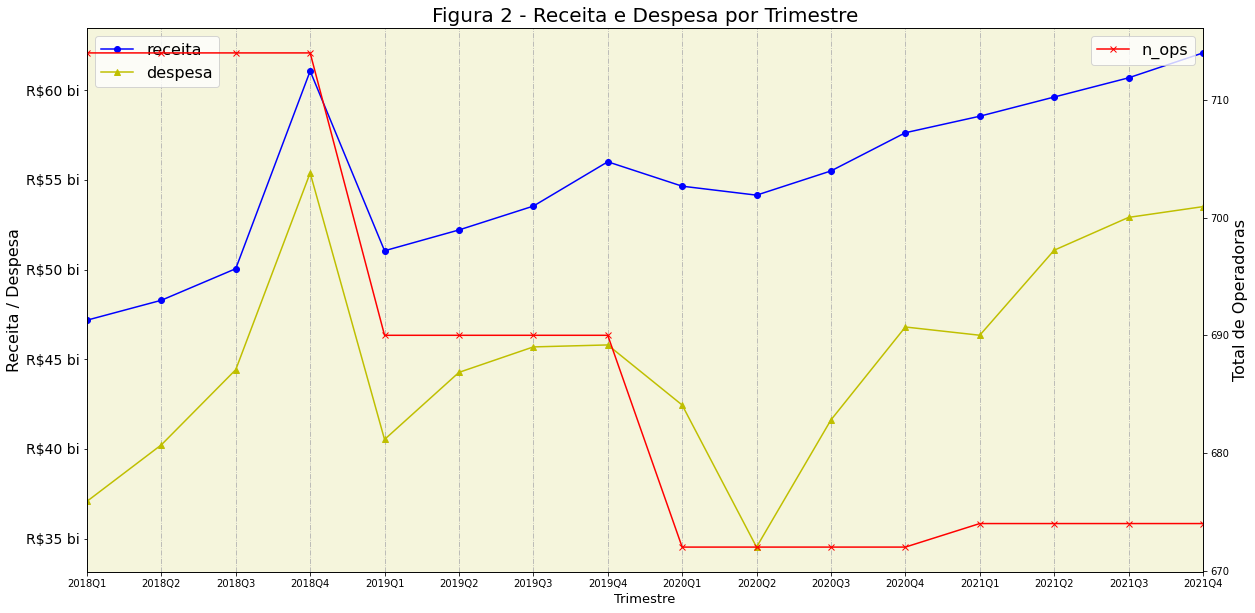

In [115]:
df_plot = diops_tcc_analise15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)


plt.show()

In [116]:
#Cria o rankin das operadoras com maior receita e despesa
diops_tcc_analise16 = diops_tcc_analise14.groupby(['ano','cd_ops'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                         'despesa':lambda x: sum_billion(x)})

diops_tcc_analise16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

diops_tcc_analise16

,ano,cd_ops,receita,despesa
709,2018,5711,22.230,19.290
185,2018,326305,19.990,16.780
711,2018,6246,15.470,12.130
414,2018,359017,5.590,6.700
509,2018,393321,5.510,4.780
...,...,...,...,...
2736,2021,422584,0.000,0.000
2737,2021,422614,0.000,0.000
2740,2021,422720,0.000,0.000
2741,2021,422754,0.000,0.000


In [117]:
diops_tcc_trimestral_ops = diops_tcc_analise16.head(100)

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[['cd_ops']].reset_index(drop=True)

keys = list(diops_tcc_trimestral_ops.columns.values)
i1 = diops_tcc_analise14.set_index(keys).index
i2 = diops_tcc_trimestral_ops.set_index(keys).index

diops_tcc_analise16 =  diops_tcc_analise14[i1.isin(i2)]

diops_tcc_analise16.sort_values(by=['receita'], ascending=False, inplace=True)

diops_tcc_analise16.head()

,ano,cd_ops,trimestre,receita,despesa
10291,2021,5711,2021Q4,6949369996.220,6381595012.610
10290,2021,5711,2021Q3,6776296671.760,6329774938.060
10289,2021,5711,2021Q2,6722286604.220,6100189595.320
10288,2021,5711,2021Q1,6661933042.600,5771245701.700
7775,2020,5711,2020Q4,6546387457.780,5747678390.500


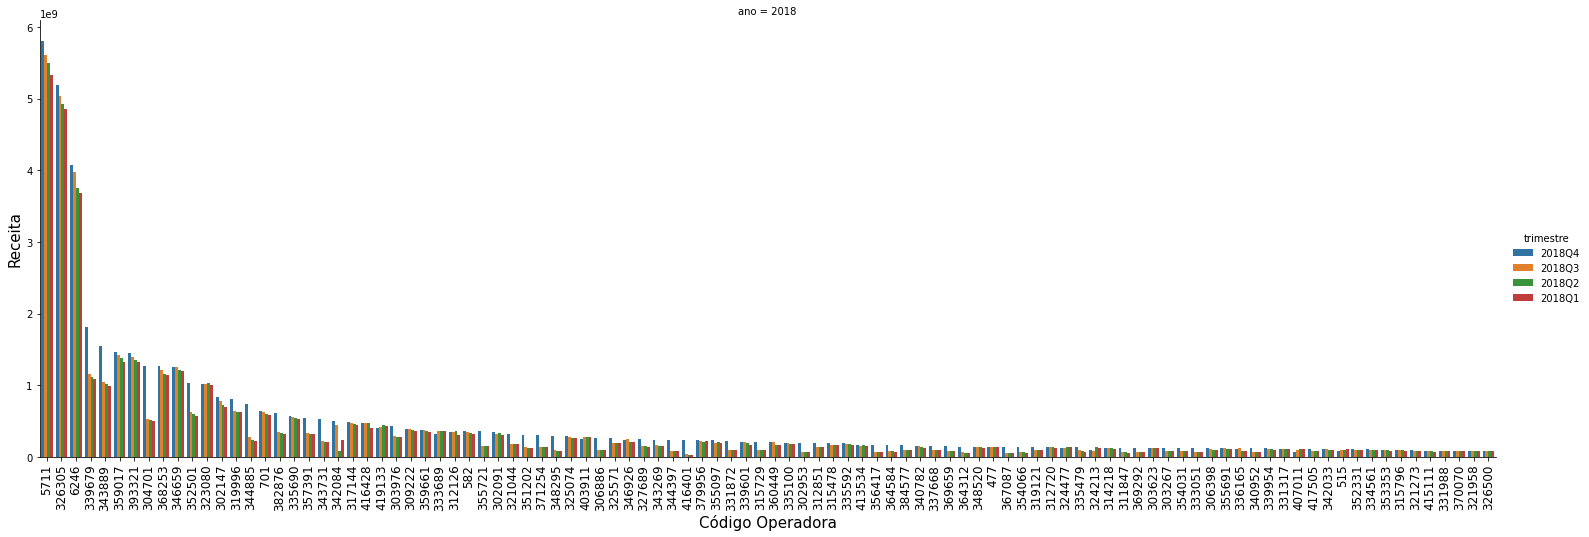

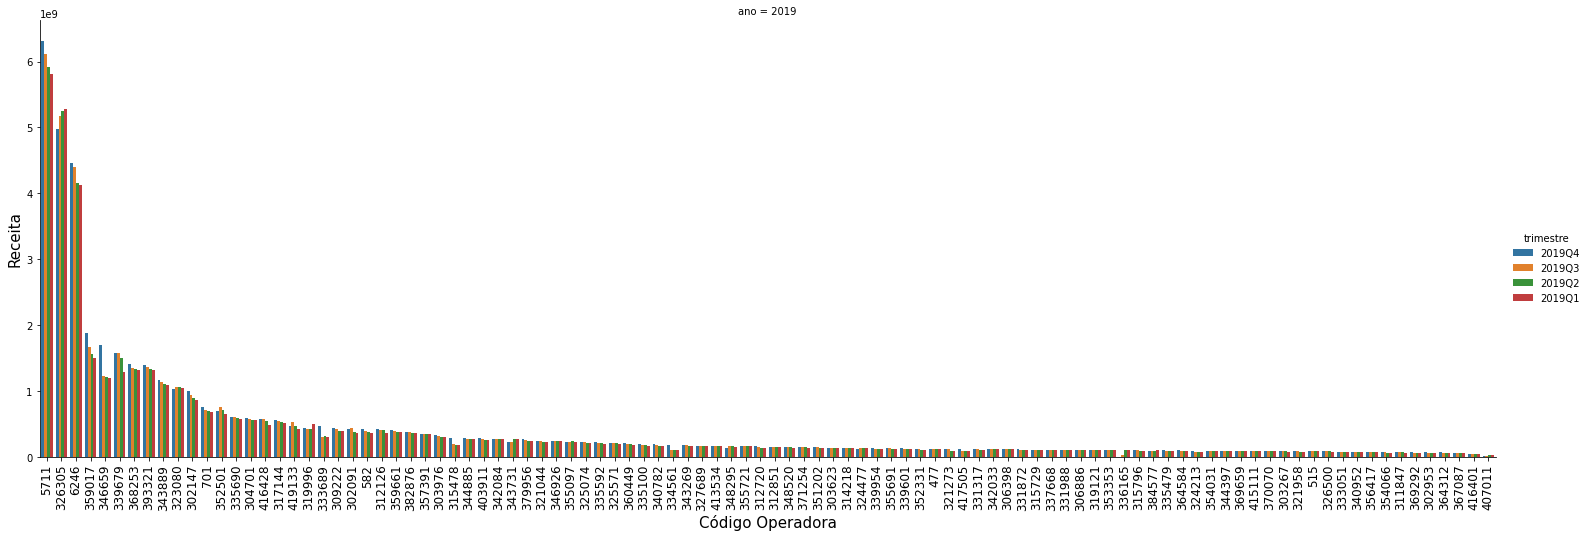

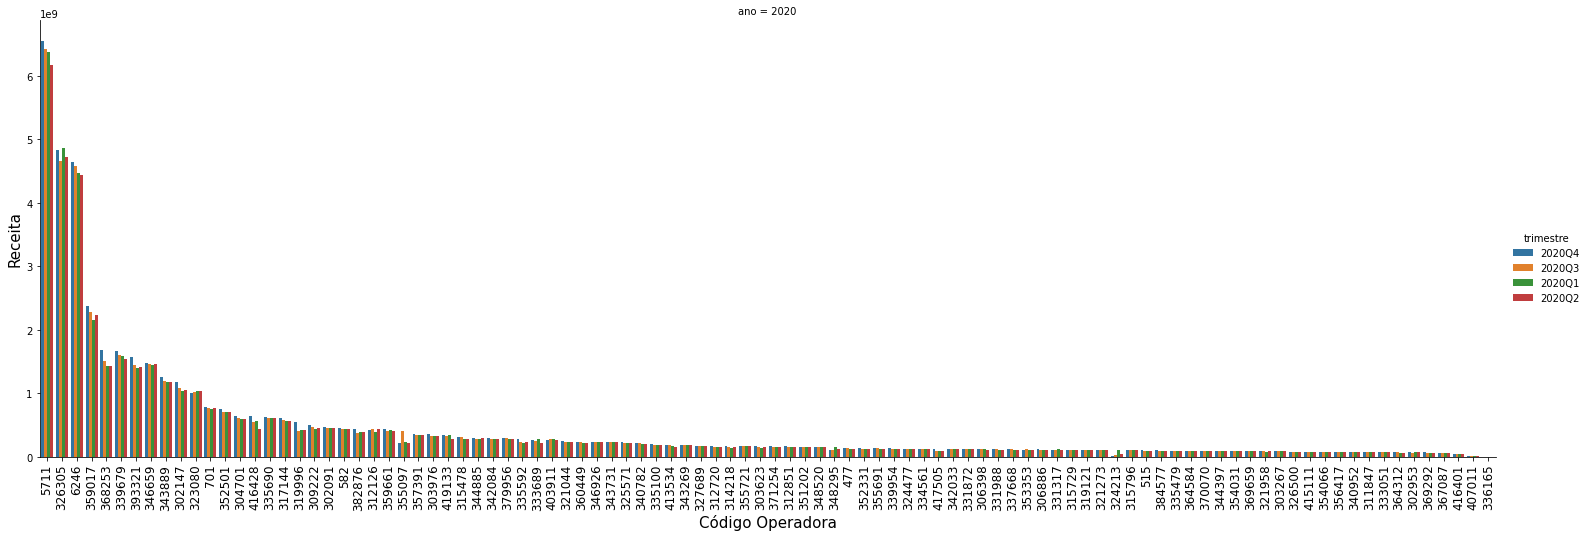

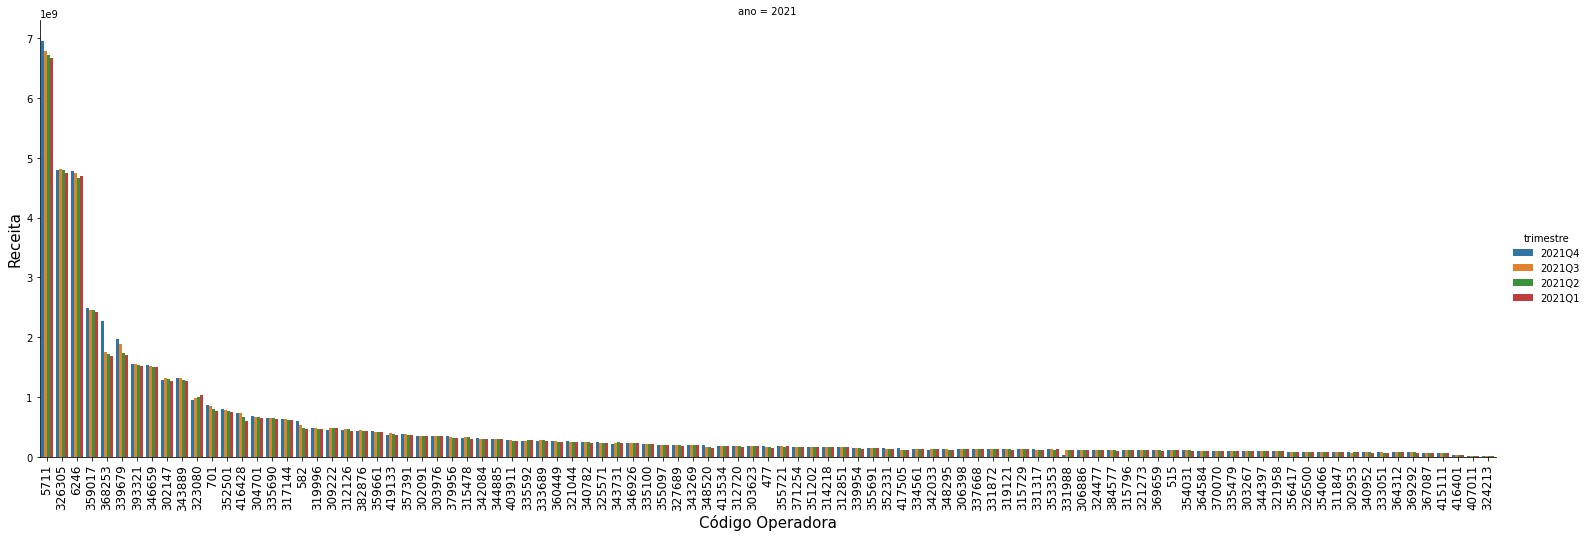

In [118]:
df_plot = diops_tcc_analise16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

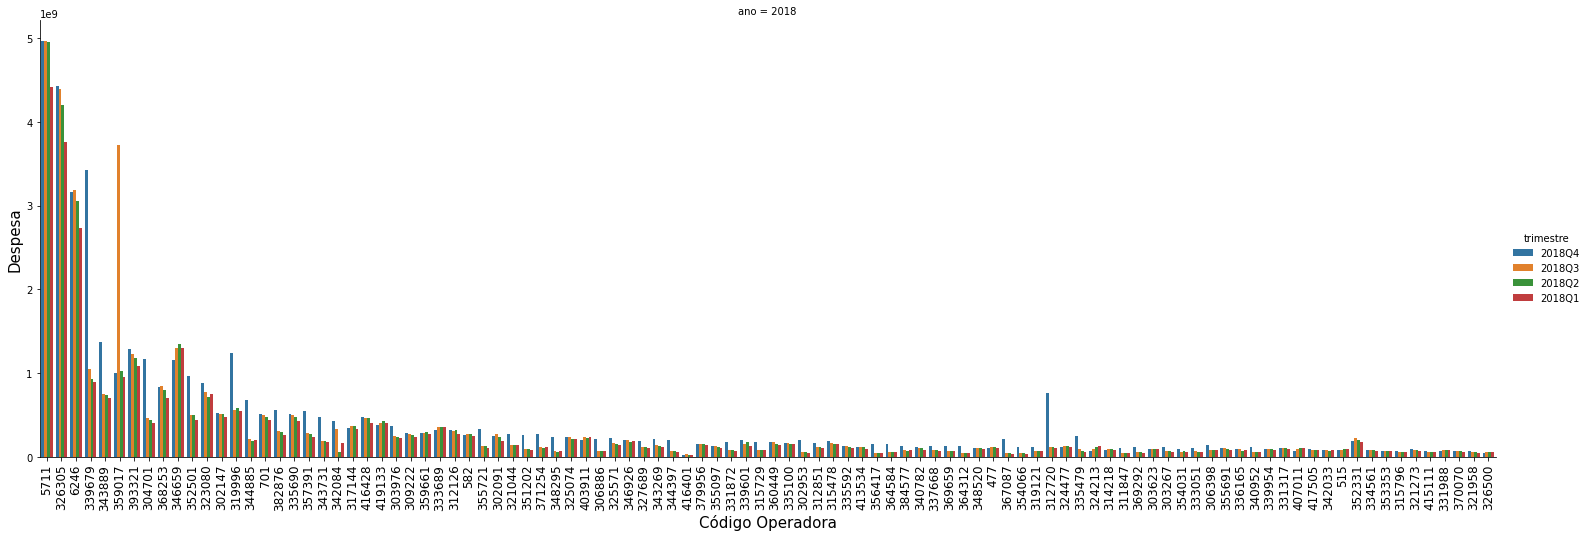

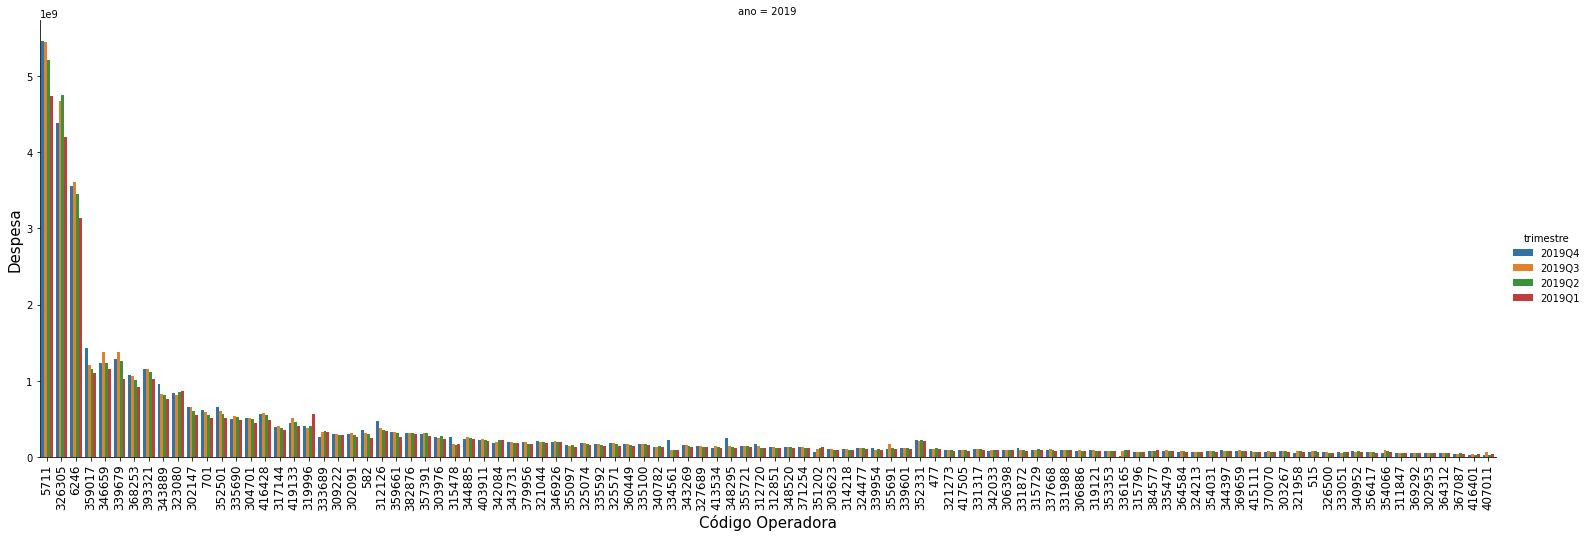

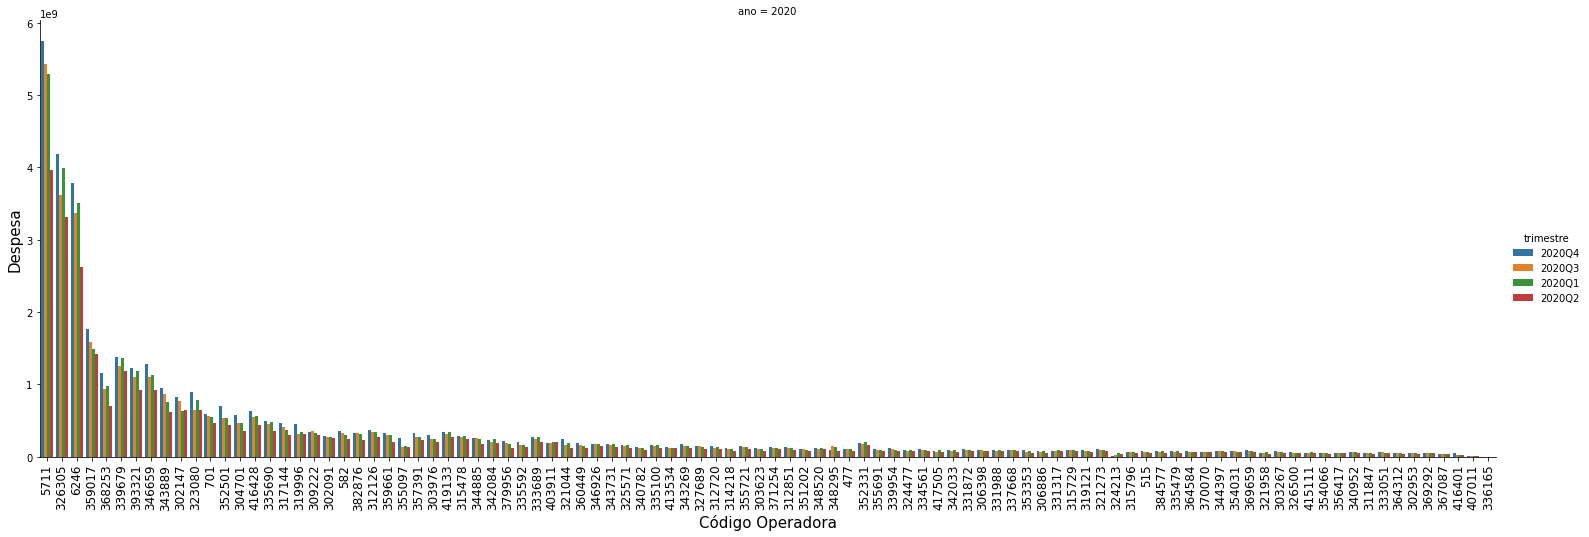

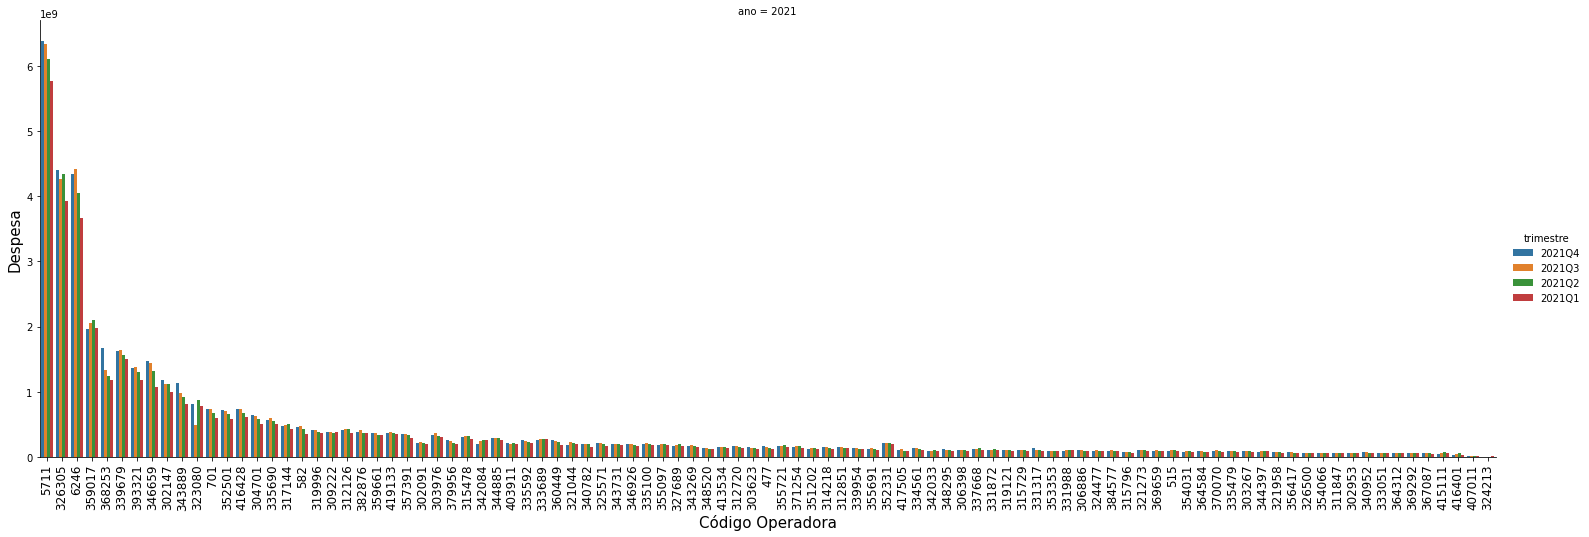

In [119]:
df_plot = diops_tcc_analise16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [120]:
diops_tcc_analise16 = diops_tcc_analise14.groupby(['ano','cd_ops'], as_index=False).agg( receita_total = ('receita','sum'),
                                                                                         despesa_total = ('despesa','sum'))

diops_tcc_analise17 = pd.merge(diops_tcc_analise14,diops_tcc_analise16, how='left', on=['ano','cd_ops'])

#diops_tcc_analise17 = diops_tcc_analise17[(diops_tcc_analise17['trimestre']=='2018Q4') | (diops_tcc_analise17['trimestre']=='2018Q3')]

diops_tcc_analise17 = diops_tcc_analise17[(diops_tcc_analise17['ano']=='2018')]

diops_tcc_analise17['pct_receita'] = diops_tcc_analise17['receita'] / diops_tcc_analise17['receita_total']

diops_tcc_analise17['pct_despesa'] = diops_tcc_analise17['despesa'] / diops_tcc_analise17['despesa_total']

diops_tcc_analise17.head()

,ano,cd_ops,trimestre,receita,despesa,receita_total,despesa_total,pct_receita,pct_despesa
0,2018,27,2018Q1,23205753.800,21011412.760,79118367.360,75924674.320,0.293,0.277
1,2018,27,2018Q2,23299209.530,19557072.570,79118367.360,75924674.320,0.294,0.258
2,2018,27,2018Q3,19029243.290,19869707.410,79118367.360,75924674.320,0.241,0.262
3,2018,27,2018Q4,13584160.740,15486481.580,79118367.360,75924674.320,0.172,0.204
4,2018,300012,2018Q1,4890415.420,3805978.920,20390875.840,15644601.650,0.240,0.243


In [121]:
stats_diops_tcc3 = diops_tcc_analise17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.51])

stats_diops_tcc3

pct_receita                                     pct_despesa                                    
                     count  mean   std   min   50%   51%   max       count  mean   std   min   50%   51%   max
ano  trimestre                                                                                                
2018 2018Q1        714.000 0.228 0.048 0.005 0.237 0.238 0.753     714.000 0.213 0.050 0.001 0.224 0.225 0.667
     2018Q2        714.000 0.232 0.038 0.004 0.244 0.244 0.419     714.000 0.229 0.048 0.002 0.245 0.246 0.461
     2018Q3        714.000 0.238 0.041 0.003 0.251 0.251 0.739     714.000 0.236 0.049 0.010 0.253 0.254 0.556
     2018Q4        714.000 0.302 0.094 0.010 0.264 0.264 0.929     714.000 0.322 0.122 0.072 0.269 0.269 0.939

In [122]:
stats_diops_tcc4 = stats_diops_tcc3.reset_index(level=[0,1])

stats_diops_tcc4.columns = ['_'.join(col) for col in stats_diops_tcc4.columns.values]

stats_diops_tcc4 = stats_diops_tcc4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_51%', 'pct_despesa_51%']]

stats_diops_tcc4.rename(columns = {'ano_':'ano',
                                  'trimestre_':'trimestre',
                                  'pct_receita_50%':'pct_receita_50',
                                  'pct_despesa_50%':'pct_despesa_50',
                                  'pct_receita_51%':'pct_receita_ref',
                                  'pct_despesa_51%':'pct_despesa_ref'}, inplace = True)

stats_diops_tcc4

,ano,trimestre,pct_receita_mean,pct_despesa_mean,pct_receita_50,pct_despesa_50,pct_receita_ref,pct_despesa_ref
0,2018,2018Q1,0.228,0.213,0.237,0.224,0.238,0.225
1,2018,2018Q2,0.232,0.229,0.244,0.245,0.244,0.246
2,2018,2018Q3,0.238,0.236,0.251,0.253,0.251,0.254
3,2018,2018Q4,0.302,0.322,0.264,0.269,0.264,0.269


In [123]:
diops_tcc_analise18 = pd.merge(diops_tcc_analise17,stats_diops_tcc4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

diops_tcc_analise18['receita_mean'] = diops_tcc_analise18['receita_total'] * diops_tcc_analise18['pct_receita_50']

diops_tcc_analise18['despesa_mean'] = diops_tcc_analise18['despesa_total'] * diops_tcc_analise18['pct_despesa_50']

diops_tcc_analise18 = diops_tcc_analise18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

diops_tcc_analise18.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,27,2018Q1,18753945.107,17040532.034
1,2018,27,2018Q2,19301098.588,18596318.891
2,2018,27,2018Q3,19861991.173,19239626.079
3,2018,27,2018Q4,20860548.034,20403483.555
4,2018,300012,2018Q1,4833382.929,3511274.009


In [124]:
diops_tcc_analise19 = pd.merge(diops_tcc_analise17,stats_diops_tcc4, how='left', on=['ano','trimestre'])

#diops_tcc_analise18 = diops_tcc_analise18[(diops_tcc_analise18['pct_receita'] > diops_tcc_analise18['pct_receita_ref']) | (diops_tcc_analise18['pct_despesa'] > diops_tcc_analise18['pct_despesa_ref'])]

diops_tcc_analise19 = diops_tcc_analise19[(diops_tcc_analise19['pct_receita'] > diops_tcc_analise19['pct_receita_50'])]

diops_tcc_analise19 = diops_tcc_analise19[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

diops_tcc_analise19.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,27,2018Q1,23205753.800,21011412.760
1,2018,408522,2018Q3,986831.470,468625.420
2,2018,408522,2018Q2,977278.310,457337.280
3,2018,408522,2018Q1,951991.160,283241.210
4,2018,408263,2018Q3,1979247.400,1824661.980


In [125]:
diops_tcc_analise20 = pd.merge(diops_tcc_analise19,diops_tcc_analise18, how='left', on=['ano','cd_ops','trimestre'])

diops_tcc_analise20 = diops_tcc_analise20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

diops_tcc_analise20.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,27,2018Q1,18753945.107,17040532.034
1,2018,408522,2018Q3,984042.124,405905.027
2,2018,408522,2018Q2,956253.272,392332.953
3,2018,408522,2018Q1,929145.110,359509.981
4,2018,408263,2018Q3,1969388.809,1975468.201


In [126]:
diops_tcc_analise21 = pd.merge(diops_tcc_analise14,diops_tcc_analise20, how='left', on=['ano','cd_ops','trimestre'])

#diops_tcc_analise21['receita_diff'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_mean']) / 4.0

#diops_tcc_analise21['despesa_diff'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_mean'])/ 4.0

diops_tcc_analise21.fillna(0, inplace=True)

diops_tcc_analise21['receita_corrigida'] = np.where(diops_tcc_analise21['receita_mean'] == 0, diops_tcc_analise21['receita'], diops_tcc_analise21['receita_mean'])

diops_tcc_analise21['despesa_corrigida'] = np.where(diops_tcc_analise21['despesa_mean'] == 0, diops_tcc_analise21['despesa'], diops_tcc_analise21['despesa_mean'])

diops_tcc_analise21['receita_diff_tri'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_corrigida']) / 4.0

diops_tcc_analise21['despesa_diff_tri'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

diops_tcc_analise21.sort_values(by=['ano'], ignore_index=False, inplace=True)

diops_tcc_analise21[diops_tcc_analise21['cd_ops']=='300012']

,ano,cd_ops,trimestre,receita,despesa,receita_mean,despesa_mean,receita_corrigida,despesa_corrigida,receita_diff_tri,despesa_diff_tri
4,2018,300012,2018Q1,4890415.420,3805978.920,4833382.929,3511274.009,4833382.929,3511274.009,14258.123,73676.228
5,2018,300012,2018Q2,4819798.380,3667127.160,0.000,0.000,4819798.380,3667127.160,0.000,0.000
6,2018,300012,2018Q3,5191346.120,4051667.270,5118955.427,3964406.678,5118955.427,3964406.678,18097.673,21815.148
7,2018,300012,2018Q4,5489315.920,4119828.300,5376309.688,4204224.455,5376309.688,4204224.455,28251.558,-21099.039
2672,2019,300012,2019Q1,5404309.720,4749396.120,0.000,0.000,5404309.720,4749396.120,0.000,0.000
2673,2019,300012,2019Q2,15586110.070,13672212.360,0.000,0.000,15586110.070,13672212.360,0.000,0.000
2674,2019,300012,2019Q3,5193069.290,4415964.750,0.000,0.000,5193069.290,4415964.750,0.000,0.000
2675,2019,300012,2019Q4,10201126.690,9393758.350,0.000,0.000,10201126.690,9393758.350,0.000,0.000
5263,2020,300012,2020Q4,5095946.890,3439589.030,0.000,0.000,5095946.890,3439589.030,0.000,0.000
5262,2020,300012,2020Q3,5041079.870,4026865.790,0.000,0.000,5041079.870,4026865.790,0.000,0.000


In [127]:
diops_tcc_analise22 = diops_tcc_analise21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

diops_tcc_analise22 = diops_tcc_analise22[diops_tcc_analise22['receita_diff_tri']!=0]

diops_tcc_analise22.head()

,ano,cd_ops,receita_diff_tri,despesa_diff_tri
0,2018,27,2112479.909,1232908.601
1,2018,300012,60607.354,74392.337
2,2018,300136,1976140.941,3642167.893
3,2018,300713,5240114.086,4692626.018
4,2018,301060,2043831.816,2417939.009


In [128]:
diops_tcc_analise23 = diops_tcc_analise21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

diops_tcc_analise23.sort_values(by=['ano'], ignore_index=False, inplace=True)

diops_tcc_analise23.head()

,ano,cd_ops,trimestre,receita_corrigida,despesa_corrigida
0,2018,27,2018Q1,18753945.107,17040532.034
1898,2018,27,2018Q2,19301098.588,18596318.891
1899,2018,27,2018Q3,19029243.290,19869707.410
1900,2018,27,2018Q4,13584160.740,15486481.580
1901,2018,300012,2018Q1,4833382.929,3511274.009


In [129]:
diops_tcc_analise24 = pd.merge(diops_tcc_analise23, diops_tcc_analise22, how='left', on = ['ano','cd_ops'])

diops_tcc_analise24.fillna(0, inplace=True)

diops_tcc_analise24.sort_values(by=['ano'], ignore_index=False, inplace=True)

diops_tcc_analise24['receita'] = diops_tcc_analise24['receita_corrigida'] + diops_tcc_analise24['receita_diff_tri']

diops_tcc_analise24['despesa'] = diops_tcc_analise24['despesa_corrigida'] + diops_tcc_analise24['despesa_diff_tri']

diops_tcc_analise24 = diops_tcc_analise24[['ano','cd_ops','trimestre','receita','despesa']]

diops_tcc_analise24[diops_tcc_analise24['cd_ops']=='342084']

,ano,cd_ops,trimestre,receita,despesa
1048,2018,342084,2018Q4,408009446.076,322985700.559
1040,2018,342084,2018Q1,310453941.343,225715979.796
1041,2018,342084,2018Q2,158546252.223,117893368.066
1042,2018,342084,2018Q3,391993296.718,308045333.610
3695,2019,342084,2019Q1,266070034.890,225561079.020
3692,2019,342084,2019Q4,276905080.430,184037585.490
3693,2019,342084,2019Q3,268637676.190,196724239.350
3694,2019,342084,2019Q2,268501971.520,220265723.230
6330,2020,342084,2020Q1,284858475.390,241688474.860
6331,2020,342084,2020Q2,284660769.750,188116134.460


In [130]:
diops_tcc_analise25 = diops_tcc_analise24.groupby(['ano','trimestre'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                            'despesa':lambda x: sum_billion(x),
                                                                                            'cd_ops':lambda x: x.nunique()})

diops_tcc_analise25['pct_despesa'] = diops_tcc_analise25.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_analise25.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_analise25 = diops_tcc_analise25[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_analise25.set_index('trimestre', inplace=True)

diops_tcc_analise25

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,48.790,39.430,714,80.820
2018Q2,50.040,43.360,714,86.650
2018Q3,51.720,44.930,714,86.870
2018Q4,56.030,49.390,714,88.150
2019Q1,51.050,40.530,690,79.390
2019Q2,52.210,44.270,690,84.790
2019Q3,53.540,45.690,690,85.340
2019Q4,56.010,45.800,690,81.770
2020Q1,54.650,42.450,672,77.680


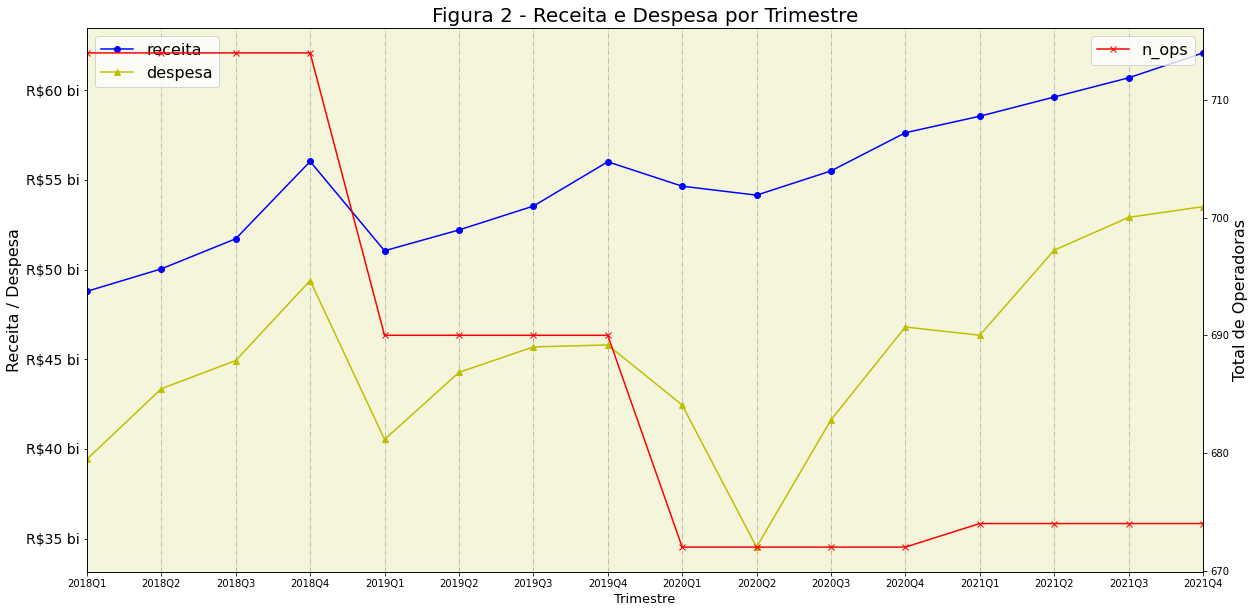

In [131]:
df_plot = diops_tcc_analise25.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [132]:
#Cria o rankin das operadoras com maior receita e despesa
diops_tcc_analise16 = diops_tcc_analise14.groupby(['ano','cd_ops'], as_index=False).agg({'receita':lambda x: sum_billion(x),
                                                                                         'despesa':lambda x: sum_billion(x)})

diops_tcc_analise16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

diops_tcc_analise16

,ano,cd_ops,receita,despesa
709,2018,5711,22.230,19.290
185,2018,326305,19.990,16.780
711,2018,6246,15.470,12.130
414,2018,359017,5.590,6.700
509,2018,393321,5.510,4.780
...,...,...,...,...
2736,2021,422584,0.000,0.000
2737,2021,422614,0.000,0.000
2740,2021,422720,0.000,0.000
2741,2021,422754,0.000,0.000


In [ ]:
diops_tcc_trimestral_ops = diops_tcc_analise16.head(100)

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[['cd_ops']].reset_index(drop=True)

keys = list(diops_tcc_trimestral_ops.columns.values)
i1 = diops_tcc_analise24.set_index(keys).index
i2 = diops_tcc_trimestral_ops.set_index(keys).index

diops_tcc_analise25 =  diops_tcc_analise24[i1.isin(i2)]

diops_tcc_analise25.sort_values(by=['receita'], ascending=False, inplace=True)

diops_tcc_analise25.head()

In [ ]:
df_plot = diops_tcc_analise25.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
df_plot = diops_tcc_analise25.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
#############################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas trimestre a trimestre resumidas 

diops_tcc_trimestral = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                        'despesa':lambda x: sum_billion(x),
                                                                                                                                        'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral['pct_despesa'] = diops_tcc_trimestral.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral = diops_tcc_trimestral[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral = diops_tcc_trimestral[diops_tcc_trimestral['trimestre'] >= '2018Q1']

diops_tcc_trimestral.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '05-diops_trimestral_tcc_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral.set_index('trimestre', inplace=True)

diops_tcc_trimestral

In [ ]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral.index)
ax1.set_xticklabels(diops_tcc_trimestral.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

diops_tcc_trimestral.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral.index)
ax2.set_xticklabels(diops_tcc_trimestral.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)


plt.show()

In [ ]:
diops_tcc_trimestral_ops = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','id_calendar','trimestre'], as_index=False).agg({'receita': 'sum',
                                                                                                                                         'despesa': 'sum'})

diops_tcc_trimestral_ops['receita'] = diops_tcc_trimestral_ops['receita'].apply(np.floor)

diops_tcc_trimestral_ops['despesa'] = diops_tcc_trimestral_ops['despesa'].apply(np.floor)

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[(diops_tcc_trimestral_ops['receita'] != 0) & (diops_tcc_trimestral_ops['despesa'] != 0)]

diops_tcc_trimestral_ops['ano'] = diops_tcc_trimestral_ops['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[['cd_ops','ano','trimestre','receita','despesa']]

diops_tcc_trimestral_ops = diops_tcc_trimestral_ops[(diops_tcc_trimestral_ops['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops['trimestre'] < '2022Q1') ]

diops_tcc_trimestral_ops.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops.head()

In [ ]:
diops_tcc_trimestral_ops_top = diops_tcc_trimestral_ops.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_top = diops_tcc_trimestral_ops_top[['ano','trimestre','cd_ops','receita','despesa']]

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top[diops_tcc_trimestral_ops_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Agrupamento - Contrato

In [ ]:
diops_tcc_trimestral_cont = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'contratacao', 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                                                'despesa':lambda x: sum_billion(x),
                                                                                                                                                                'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral_cont['pct_despesa'] = diops_tcc_trimestral_cont.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral_cont.columns = ['contratacao', 'ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral_cont = diops_tcc_trimestral_cont[['contratacao','trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral_cont = diops_tcc_trimestral_cont[diops_tcc_trimestral_cont['trimestre'] >= '2018Q1']

diops_tcc_trimestral_cont.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '06-diops_contrato_trimestral_tcc_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_cont.set_index('trimestre', inplace=True)

In [ ]:
diops_tcc_trimestral_ops_cont = diops_tcc.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','contratacao','id_calendar','trimestre'], as_index=False).agg({'receita': 'sum',
                                                                                                                                                                    'despesa': 'sum'})

diops_tcc_trimestral_ops_cont['receita'] = diops_tcc_trimestral_ops_cont['receita'].apply(np.floor)

diops_tcc_trimestral_ops_cont['despesa'] = diops_tcc_trimestral_ops_cont['despesa'].apply(np.floor)

diops_tcc_trimestral_ops_cont = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['receita'] != 0) & (diops_tcc_trimestral_ops_cont['despesa'] != 0)]

diops_tcc_trimestral_ops_cont['ano'] = diops_tcc_trimestral_ops_cont['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops_cont = diops_tcc_trimestral_ops_cont[['ano','trimestre','cd_ops','contratacao','receita','despesa']]

diops_tcc_trimestral_ops_cont = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops_cont['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_tcc_trimestral_ops_cont.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops_cont.head(20)

## Adesão

In [ ]:
df_tcc_trimestral_cont_ade = diops_tcc_trimestral_cont[(diops_tcc_trimestral_cont['contratacao']=='Adesao')]
df_tcc_trimestral_cont_ade 

In [ ]:
fig,ax1 = plt.subplots()

df_tcc_trimestral_cont_ade.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos por Adesão',fontsize = 20)
ax1.set_xticks(df_tcc_trimestral_cont_ade.index)
ax1.set_xticklabels(df_tcc_trimestral_cont_ade.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_tcc_trimestral_cont_ade.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_tcc_trimestral_cont_ade.index)
ax2.set_xticklabels(df_tcc_trimestral_cont_ade.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
diops_tcc_trimestral_ops_cont_ade = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['contratacao']=='Adesao')] 

diops_tcc_trimestral_ops_cont_ade_top = diops_tcc_trimestral_ops_cont_ade.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_cont_ade_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ade_top = diops_tcc_trimestral_ops_cont_ade_top[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ade_top.head()

### Receita

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Despesa

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top[diops_tcc_trimestral_ops_cont_ade_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Empresarial

In [ ]:
df_tcc_trimestral_cont_emp = diops_tcc_trimestral_cont[(diops_tcc_trimestral_cont['contratacao']=='Empresarial')]
df_tcc_trimestral_cont_emp 

In [ ]:
fig,ax1 = plt.subplots()

df_tcc_trimestral_cont_emp.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Empresarial',fontsize = 20)
ax1.set_xticks(df_tcc_trimestral_cont_emp.index)
ax1.set_xticklabels(df_tcc_trimestral_cont_emp.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_tcc_trimestral_cont_emp.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_tcc_trimestral_cont_emp.index)
ax2.set_xticklabels(df_tcc_trimestral_cont_emp.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
diops_tcc_trimestral_ops_cont_emp = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['contratacao']=='Empresarial')] 

diops_tcc_trimestral_ops_cont_emp_top = diops_tcc_trimestral_ops_cont_emp.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_cont_emp_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_emp_top = diops_tcc_trimestral_ops_cont_emp_top[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_emp_top.sort_values(by=['trimestre','receita'],ascending = False, inplace=True)

diops_tcc_trimestral_ops_cont_emp_top.head()

### Receita

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Despesa

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top[diops_tcc_trimestral_ops_cont_emp_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Individual

In [ ]:
df_tcc_trimestral_cont_ind = diops_tcc_trimestral_cont[(diops_tcc_trimestral_cont['contratacao']=='Individual')] 
df_tcc_trimestral_cont_ind

In [ ]:
fig,ax1 = plt.subplots()

df_tcc_trimestral_cont_ind.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Individual',fontsize = 20)
ax1.set_xticks(df_tcc_trimestral_cont_ind.index)
ax1.set_xticklabels(df_tcc_trimestral_cont_ind.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_tcc_trimestral_cont_ind.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_tcc_trimestral_cont_ind.index)
ax2.set_xticklabels(df_tcc_trimestral_cont_ind.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
diops_tcc_trimestral_ops_cont_ind = diops_tcc_trimestral_ops_cont[(diops_tcc_trimestral_ops_cont['contratacao']=='Individual')] 

diops_tcc_trimestral_ops_cont_ind_top = diops_tcc_trimestral_ops_cont_ind.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(100).reset_index()

diops_tcc_trimestral_ops_cont_ind_top.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ind_top = diops_tcc_trimestral_ops_cont_ind_top[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ind_top.head()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top[diops_tcc_trimestral_ops_cont_ind_top['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

# Dados Filtrados

In [ ]:
# filtra os tipos de planos relevantes para a análise

diops_filtrada = diops.loc[  (diops['vigencia'] == 'P') & # planos novos
                    (diops['financiamento'] == 'Pre-estabelecido'), # financiamento pre-estabelecido
                    ['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre', 'receita', 'despesa']]

diops_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '07-diops_trimestral_acumulada_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')



diops_tcc_filtrada = diops_tcc.loc[  (diops_tcc['vigencia'] == 'P') & # planos novos
                            (diops_tcc['financiamento'] == 'Pre-estabelecido'), # financiamento pre-estabelecido
                            ['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre', 'receita', 'despesa']]

diops_tcc_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '08-diops_trimestral_tcc_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

In [ ]:
###########################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas acumuladas resumidas por trimestre

diops_trimestral_ops_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({ 'receita':lambda x: sum_billion(x),
                                                                                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                                                                                    'cd_ops':lambda x: x.nunique()})

diops_trimestral_ops_filtrada['pct_despesa'] = diops_trimestral_ops_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_trimestral_ops_filtrada.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[diops_trimestral_ops_filtrada['trimestre'] >= '2018Q1']

diops_trimestral_ops_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '09-diops_trimestral_acumulada_filtrada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops_filtrada.set_index('trimestre', inplace=True)

diops_trimestral_ops_filtrada

In [ ]:
fig,ax1 = plt.subplots()

diops_trimestral_ops_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre',fontsize = 20)
ax1.set_xticks(diops_trimestral_ops_filtrada.index)
ax1.set_xticklabels(diops_trimestral_ops_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_trimestral_ops_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_trimestral_ops_filtrada.index)
ax2.set_xticklabels(diops_trimestral_ops_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
diops_trimestral_ops_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','id_calendar','trimestre'], as_index=False).agg({ 'receita': 'sum',
                                                                                                                                                        'despesa': 'sum'})

diops_trimestral_ops_filtrada['receita'] = diops_trimestral_ops_filtrada['receita'].apply(np.floor)

diops_trimestral_ops_filtrada['despesa'] = diops_trimestral_ops_filtrada['despesa'].apply(np.floor)

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[(diops_trimestral_ops_filtrada['receita'] != 0) & (diops_trimestral_ops_filtrada['despesa'] != 0)]

diops_trimestral_ops_filtrada['ano'] = diops_trimestral_ops_filtrada['id_calendar'].dt.to_period('Y')

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[['cd_ops','ano','trimestre','receita','despesa']]

diops_trimestral_ops_filtrada = diops_trimestral_ops_filtrada[(diops_trimestral_ops_filtrada['trimestre'] >= '2018Q1') & (diops_trimestral_ops_filtrada['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_trimestral_ops_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops_filtrada.head()

In [ ]:
diops_trimestral_ops_top_filtrada = diops_trimestral_ops_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_trimestral_ops_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_trimestral_ops_top_filtrada = diops_trimestral_ops_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 10)
ax[0].set_xlabels('Código Operadora', fontsize=12)
ax[0].set_ylabels('Receita', fontsize= 12)

ax[1].set_xticklabels(rotation = 90, fontsize= 10)
ax[1].set_xlabels('Código Operadora', fontsize=12)
ax[1].set_ylabels('Receita', fontsize= 12)

ax[2].set_xticklabels(rotation = 90, fontsize= 10)
ax[2].set_xlabels('Código Operadora', fontsize=12)
ax[2].set_ylabels('Receita', fontsize= 12)

ax[3].set_xticklabels(rotation = 90, fontsize= 10)
ax[3].set_xlabels('Código Operadora', fontsize=12)
ax[3].set_ylabels('Receita', fontsize= 12)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_top_filtrada[diops_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 10)
ax[0].set_xlabels('Código Operadora', fontsize=12)
ax[0].set_ylabels('Despesa', fontsize= 12)

ax[1].set_xticklabels(rotation = 90, fontsize= 10)
ax[1].set_xlabels('Código Operadora', fontsize=12)
ax[1].set_ylabels('Despesa', fontsize= 12)

ax[2].set_xticklabels(rotation = 90, fontsize= 10)
ax[2].set_xlabels('Código Operadora', fontsize=12)
ax[2].set_ylabels('Despesa', fontsize= 12)

ax[3].set_xticklabels(rotation = 90, fontsize= 10)
ax[3].set_xlabels('Código Operadora', fontsize=12)
ax[3].set_ylabels('Despesa', fontsize= 12)

fig.tight_layout()

plt.close(1)
fig.show()

## Agrupamento - Contrato - Base Filtrada

In [ ]:
diops_trimestral_cont_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'contratacao','id_calendar','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                                                                                                        'despesa':lambda x: sum_billion(x),
                                                                                                                                                                        'cd_ops':lambda x: x.nunique()})

diops_trimestral_cont_filtrada['pct_despesa'] = diops_trimestral_cont_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_trimestral_cont_filtrada.columns = ['contratacao', 'ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_trimestral_cont_filtrada = diops_trimestral_cont_filtrada[['contratacao','trimestre','receita','despesa','n_ops','pct_despesa']]

diops_trimestral_cont_filtrada = diops_trimestral_cont_filtrada[diops_trimestral_cont_filtrada['trimestre'] >= '2018Q1']

diops_trimestral_cont_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '10-diops_contrato_trimestral_acumulada_resumo_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_cont_filtrada.set_index('trimestre', inplace=True)

In [ ]:
diops_trimestral_ops_cont_filtrada = diops_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','contratacao','id_calendar','trimestre'], as_index=False).agg({  'receita': 'sum',
                                                                                                                                                                                'despesa': 'sum'})

diops_trimestral_ops_cont_filtrada['receita'] = diops_trimestral_ops_cont_filtrada['receita'].apply(np.floor)

diops_trimestral_ops_cont_filtrada['despesa'] = diops_trimestral_ops_cont_filtrada['despesa'].apply(np.floor)

diops_trimestral_ops_cont_filtrada = diops_trimestral_ops_cont_filtrada[(diops_trimestral_ops_cont_filtrada['receita'] != 0) & (diops_trimestral_ops_cont_filtrada['despesa'] != 0)]

diops_trimestral_ops_cont_filtrada['ano'] = diops_trimestral_ops_cont_filtrada['id_calendar'].dt.to_period('Y')

diops_trimestral_ops_cont_filtrada = diops_trimestral_ops_cont_filtrada[['ano','trimestre','cd_ops','contratacao','receita','despesa']]

diops_trimestral_ops_cont_filtrada = diops_trimestral_ops_cont_filtrada[(diops_trimestral_ops_cont_filtrada['trimestre'] >= '2018Q1') & (diops_trimestral_ops_cont_filtrada['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_trimestral_ops_cont_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_trimestral_ops_cont_filtrada.head(20)

## Adesão Filtrada

In [ ]:
diops_trimestral_cont_ade_filtrada = diops_trimestral_cont_filtrada[(diops_trimestral_cont_filtrada['contratacao']=='Adesao')] 
diops_trimestral_cont_ade_filtrada

In [ ]:
fig,ax1 = plt.subplots()

diops_trimestral_cont_ade_filtrada.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Adesão',fontsize = 20)
ax1.set_xticks(diops_trimestral_cont_ade_filtrada.index)
ax1.set_xticklabels(diops_trimestral_cont_ade_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

diops_trimestral_cont_ade_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_trimestral_cont_ade_filtrada.index)
ax2.set_xticklabels(diops_trimestral_cont_ade_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
diops_trimestral_ops_cont_ade_filtrada = diops_trimestral_ops_cont_filtrada[(diops_trimestral_ops_cont_filtrada['contratacao']=='Adesao')] 

diops_trimestral_ops_cont_ade_top_filtrada = diops_trimestral_ops_cont_ade_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_trimestral_ops_cont_ade_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_trimestral_ops_cont_ade_top_filtrada = diops_trimestral_ops_cont_ade_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_trimestral_ops_cont_ade_top_filtrada.head()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_trimestral_ops_cont_ade_top_filtrada[diops_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Empresarial - Filtrada

In [ ]:
df_trimestral_cont_emp_filtrada = diops_trimestral_cont_filtrada[(diops_trimestral_cont_filtrada['contratacao']=='Empresarial')] 
df_trimestral_cont_emp_filtrada

In [ ]:
fig,ax1 = plt.subplots()

df_trimestral_cont_emp_filtrada.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Empresarial',fontsize = 20)
ax1.set_xticks(df_trimestral_cont_emp_filtrada.index)
ax1.set_xticklabels(df_trimestral_cont_emp_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_trimestral_cont_emp_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_trimestral_cont_emp_filtrada.index)
ax2.set_xticklabels(df_trimestral_cont_emp_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

## Individual - Filtrada

In [ ]:
df_trimestral_cont_ind_filtrada = diops_trimestral_cont_filtrada[(diops_trimestral_cont_filtrada['contratacao']=='Individual')] 
df_trimestral_cont_ind_filtrada

In [ ]:
fig,ax1 = plt.subplots()

df_trimestral_cont_ind_filtrada.plot(y=['receita','despesa'],figsize=(20, 10), ax = ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre - Contratos: Individual',fontsize = 20)
ax1.set_xticks(df_trimestral_cont_ind_filtrada.index)
ax1.set_xticklabels(df_trimestral_cont_ind_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_trimestral_cont_ind_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_trimestral_cont_ind_filtrada.index)
ax2.set_xticklabels(df_trimestral_cont_ind_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
###########################################################################################################################################################################################
#             Criação do DataFrame com as informações de despesas acumuladas resumidas por trimestre

diops_tcc_trimestral_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'id_calendar', 'trimestre'], as_index=False).agg({ 'receita':lambda x: sum_billion(x),
                                                                                                                                                            'despesa':lambda x: sum_billion(x),
                                                                                                                                                            'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral_filtrada['pct_despesa'] = diops_tcc_trimestral_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral_filtrada.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral_filtrada = diops_tcc_trimestral_filtrada[['trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral_filtrada = diops_tcc_trimestral_filtrada[diops_tcc_trimestral_filtrada['trimestre'] >= '2018Q1']

diops_tcc_trimestral_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '11-diops_trimestral_tcc_resumo_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_filtrada.set_index('trimestre', inplace=True)

diops_tcc_trimestral_filtrada

In [ ]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita, Despesa e Beneficiário por Trimestre',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [ ]:
diops_tcc_trimestral_ops_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','id_calendar','trimestre'], as_index=False).agg({'receita': 'sum',
                                                                                                                                         'despesa': 'sum'})

diops_tcc_trimestral_ops_filtrada['receita'] = diops_tcc_trimestral_ops_filtrada['receita'].apply(np.floor)

diops_tcc_trimestral_ops_filtrada['despesa'] = diops_tcc_trimestral_ops_filtrada['despesa'].apply(np.floor)

diops_tcc_tridiops_tcc_trimestral_ops_filtradamestral_ops = diops_tcc_trimestral_ops_filtrada[(diops_tcc_trimestral_ops_filtrada['receita'] != 0) & (diops_tcc_trimestral_ops_filtrada['despesa'] != 0)]

diops_tcc_trimestral_ops_filtrada['ano'] = diops_tcc_trimestral_ops_filtrada['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops_filtrada = diops_tcc_trimestral_ops_filtrada[['cd_ops','ano','trimestre','receita','despesa']]

diops_tcc_trimestral_ops_filtrada = diops_tcc_trimestral_ops_filtrada[(diops_tcc_trimestral_ops_filtrada['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops_filtrada['trimestre'] < '2022Q1') ]

diops_tcc_trimestral_ops_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops_filtrada.head()

In [ ]:
diops_tcc_trimestral_ops_top_filtrada = diops_tcc_trimestral_ops_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_top_filtrada = diops_tcc_trimestral_ops_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_top_filtrada[diops_tcc_trimestral_ops_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Agrupamento - Contrato - Filtrada

In [ ]:
diops_tcc_trimestral_cont_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'contratacao', 'id_calendar', 'trimestre'], as_index=False).agg({   'receita':lambda x: sum_billion(x),
                                                                                                                                                                                  'despesa':lambda x: sum_billion(x),
                                                                                                                                                                                  'cd_ops':lambda x: x.nunique()})

diops_tcc_trimestral_cont_filtrada['pct_despesa'] = diops_tcc_trimestral_cont_filtrada.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

diops_tcc_trimestral_cont_filtrada.columns = ['contratacao', 'ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

diops_tcc_trimestral_cont_filtrada = diops_tcc_trimestral_cont_filtrada[['contratacao','trimestre','receita','despesa','n_ops','pct_despesa']]

diops_tcc_trimestral_cont_filtrada = diops_tcc_trimestral_cont_filtrada[diops_tcc_trimestral_cont_filtrada['trimestre'] >= '2018Q1']

diops_tcc_trimestral_cont_filtrada.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '12-diops_contrato_trimestral_tcc_resumo_filtrada.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_cont_filtrada.set_index('trimestre', inplace=True)

In [ ]:
diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_filtrada.groupby([pd.Grouper(key='id_calendar', freq='A'), 'cd_ops','contratacao','id_calendar','trimestre'], as_index=False).agg({  'receita': 'sum',
                                                                                                                                                                                    'despesa': 'sum'})

diops_tcc_trimestral_ops_cont_filtrada['receita'] = diops_tcc_trimestral_ops_cont_filtrada['receita'].apply(np.floor)

diops_tcc_trimestral_ops_cont_filtrada['despesa'] = diops_tcc_trimestral_ops_cont_filtrada['despesa'].apply(np.floor)

diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['receita'] != 0) & (diops_tcc_trimestral_ops_cont_filtrada['despesa'] != 0)]

diops_tcc_trimestral_ops_cont_filtrada['ano'] = diops_tcc_trimestral_ops_cont_filtrada['id_calendar'].dt.to_period('Y')

diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_trimestral_ops_cont_filtrada[['ano','trimestre','cd_ops','contratacao','receita','despesa']]

diops_tcc_trimestral_ops_cont_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['trimestre'] >= '2018Q1') & (diops_tcc_trimestral_ops_cont_filtrada['trimestre'] < '2022Q1') ]

#diops_trimestral_ops.set_index('trimestre', inplace=True)

diops_tcc_trimestral_ops_cont_filtrada.sort_values(by=['receita'], ascending=False, inplace=True)

#diops_trimestral_cont_ops.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '03-diops_contrato_trimestral_acumulada_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

diops_tcc_trimestral_ops_cont_filtrada.head(20)

## Adesão

In [ ]:
diops_tcc_trimestral_cont_ade_filtrada = diops_tcc_trimestral_cont_filtrada[(diops_tcc_trimestral_cont_filtrada['contratacao']=='Adesao')]
diops_tcc_trimestral_cont_ade_filtrada 

In [ ]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_cont_ade_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre - Contrato: Adesão',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_cont_ade_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_cont_ade_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_cont_ade_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_cont_ade_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_cont_ade_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [ ]:
diops_tcc_trimestral_ops_cont_ade_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['contratacao']=='Adesao')] 

diops_tcc_trimestral_ops_cont_ade_top_filtrada = diops_tcc_trimestral_ops_cont_ade_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_cont_ade_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ade_top_filtrada = diops_tcc_trimestral_ops_cont_ade_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ade_top_filtrada.head()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ade_top_filtrada[diops_tcc_trimestral_ops_cont_ade_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Empresarial

In [ ]:
diops_tcc_trimestral_cont_emp_filtrada = diops_tcc_trimestral_cont_filtrada[(diops_tcc_trimestral_cont_filtrada['contratacao']=='Empresarial')]
diops_tcc_trimestral_cont_emp_filtrada 

In [ ]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_cont_emp_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre - Contrato: Empresarial',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_cont_emp_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_cont_emp_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_cont_emp_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_cont_emp_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_cont_emp_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [ ]:
diops_tcc_trimestral_ops_cont_emp_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['contratacao']=='Empresarial')] 

diops_tcc_trimestral_ops_cont_emp_top_filtrada = diops_tcc_trimestral_ops_cont_emp_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_cont_emp_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_emp_top_filtrada = diops_tcc_trimestral_ops_cont_emp_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_emp_top_filtrada.head()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_emp_top_filtrada[diops_tcc_trimestral_ops_cont_emp_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

## Individual

In [ ]:
diops_tcc_trimestral_cont_ind_filtrada = diops_tcc_trimestral_cont_filtrada[(diops_tcc_trimestral_cont_filtrada['contratacao']=='Individual')]
diops_tcc_trimestral_cont_ind_filtrada 

In [ ]:
fig,ax1 = plt.subplots()

diops_tcc_trimestral_cont_ind_filtrada.plot(y=['receita','despesa'], figsize=(20,10), style=['bo-','y^-'], ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre - Contrato: Individual',fontsize = 20)
ax1.set_xticks(diops_tcc_trimestral_cont_ind_filtrada.index)
ax1.set_xticklabels(diops_tcc_trimestral_cont_ind_filtrada.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_tcc_trimestral_cont_ind_filtrada.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_tcc_trimestral_cont_ind_filtrada.index)
ax2.set_xticklabels(diops_tcc_trimestral_cont_ind_filtrada.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.show()


In [ ]:
diops_tcc_trimestral_ops_cont_ind_filtrada = diops_tcc_trimestral_ops_cont_filtrada[(diops_tcc_trimestral_ops_cont_filtrada['contratacao']=='Individual')] 

diops_tcc_trimestral_ops_cont_ind_top_filtrada = diops_tcc_trimestral_ops_cont_ind_filtrada.sort_values(['receita','despesa'],ascending = False).groupby('trimestre').head(60).reset_index()

diops_tcc_trimestral_ops_cont_ind_top_filtrada.sort_values(by=['trimestre','receita'], inplace=True)

diops_tcc_trimestral_ops_cont_ind_top_filtrada = diops_tcc_trimestral_ops_cont_ind_top_filtrada[['ano','trimestre','cd_ops','receita','despesa']]

diops_tcc_trimestral_ops_cont_ind_top_filtrada.head()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

In [ ]:
fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2018'], kind='bar', col='ano', height=6, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2019'], kind='bar', col='ano', height=6, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2020'], kind='bar', col='ano', height=6, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = diops_tcc_trimestral_ops_cont_ind_top_filtrada[diops_tcc_trimestral_ops_cont_ind_top_filtrada['ano'] == '2021'], kind='bar', col='ano', height=6, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

# VDA

In [ ]:
def df_trim(df, column, whisker_width = 1.5):
    #Calulos dos quantis
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]

df_VDA_analise_trim = df_trim(df_VDA,'dpb')

df_VDA_analise_trim.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '21-vda_analise_trim.csv', sep=';',  index=False, encoding='mbcs', decimal=',')

In [ ]:
#####################################################################################################################################################################################
# VDA - TCC
######################################################################################################################################################################################

df_VDA_tcc = diops_tcc_filtrada.copy() 

df_VDA_tcc

In [ ]:
df_VDA_tcc = pd.merge(df_VDA_tcc, sib_filtrada, how='inner', on=['cd_ops', 'contratacao', 'id_calendar', 'trimestre'])

df_VDA_tcc = pd.merge(df_VDA_tcc, cadop, how='inner', on='cd_ops')

df_VDA_tcc.drop(['ano_y', 'razao_social'], axis='columns', inplace=True)

df_VDA_tcc.rename(columns = {'ano_x':'ano'}, inplace = True)

df_VDA_tcc = df_VDA_tcc.loc[(df_VDA_tcc['lg_cancelada']==0) & (df_VDA_tcc['lg_nova_ops']==0) & (df_VDA_tcc['despesa']>0) & (df_VDA_tcc['n_meses']==3)]

df_VDA_tcc = df_VDA_tcc[['cd_ops', 'modalidade', 'port_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre', 'receita', 'despesa', 'benefm']]

df_VDA_tcc.sort_values(by=['cd_ops', 'contratacao', 'id_calendar', 'ano', 'trimestre'])

#Duvida Aqui
df_VDA_tcc['dpb'] = np.where(df_VDA_tcc['benefm'] >= 0, df_VDA_tcc['despesa']/df_VDA_tcc['benefm'], 'NaN')

df_VDA_tcc['dpb'] = pd.to_numeric(df_VDA_tcc['dpb'], errors='coerce')

#print("")
#print("VDA TCC")
#print(df_VDA_tcc)

df_VDA_tcc.to_csv(f'D:/TCC/Microdados_SUS/codigos/vda4' + '\\' + '22-vda_tcc.csv',  index=False, sep=';', encoding='mbcs', decimal=',')

df_VDA_tcc